# Info
Name:  

    KORUS_AOD_fine_coarse_autocorr
    
Purpose:  

    Analyse some of the AOD values from KORUS AQ
    Split up between fine mode and coarse mode AOD
    Subset for level legs only
        - interpolate within the level legs
    Run autocorrelation values for the distance/time travelled 
  
Input:

    None at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - hdf5 python loader
    - 
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - '/aod_ict/all_aod_KORUS_R2_ict.mat'
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-05-18
    Modified: 

# Prepare python environment

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import Sp_parameters as Sp
from load_utils import mat2py_time, toutc, load_ict
import load_utils as lu
import plotting_utils as pu
from path_utils import getpath
import hdf5storage as hs
from datetime import datetime
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import scipy.stats as st

In [287]:
import map_utils as mu
from scipy import interpolate
import math

In [3]:
from linfit import linfit
import Sun_utils as su

In [4]:
%matplotlib notebook

In [5]:
fp =getpath('KORUS')

Return path named:  KORUS /data/sam/KORUS-AQ/


# Load files

Load the KORUS 4STAR AOD ict files for better handling

In [6]:
ar = hs.loadmat(fp+'/aod_ict/all_aod_KORUS_R2_ict.mat')

In [7]:
ka = ar.keys()

In [8]:
ka.sort()

In [9]:
ka

[u'AOD0380',
 u'AOD0452',
 u'AOD0501',
 u'AOD0520',
 u'AOD0532',
 u'AOD0550',
 u'AOD0606',
 u'AOD0620',
 u'AOD0675',
 u'AOD0781',
 u'AOD0865',
 u'AOD1020',
 u'AOD1040',
 u'AOD1064',
 u'AOD1236',
 u'AOD1559',
 u'AOD1627',
 u'GPS_Alt',
 u'Latitude',
 u'Longitude',
 u'Start_UTC',
 u'UNCAOD0380',
 u'UNCAOD0452',
 u'UNCAOD0501',
 u'UNCAOD0520',
 u'UNCAOD0532',
 u'UNCAOD0550',
 u'UNCAOD0606',
 u'UNCAOD0620',
 u'UNCAOD0675',
 u'UNCAOD0781',
 u'UNCAOD0865',
 u'UNCAOD1020',
 u'UNCAOD1040',
 u'UNCAOD1064',
 u'UNCAOD1236',
 u'UNCAOD1559',
 u'UNCAOD1627',
 u'amass_aer',
 u'days',
 u'fl',
 u'fl1',
 u'fl2',
 u'fl_QA',
 u'fl_alt',
 u'fl_alt1',
 u'qual_flag']

In [10]:
nwl = ka[0:17]

In [11]:
nwl

[u'AOD0380',
 u'AOD0452',
 u'AOD0501',
 u'AOD0520',
 u'AOD0532',
 u'AOD0550',
 u'AOD0606',
 u'AOD0620',
 u'AOD0675',
 u'AOD0781',
 u'AOD0865',
 u'AOD1020',
 u'AOD1040',
 u'AOD1064',
 u'AOD1236',
 u'AOD1559',
 u'AOD1627']

In [12]:
nm = [380.0,452.0,501.0,520.0,532.0,550.0,606.0,620.0,675.0,781.0,865.0,1020.0,1040.0,1064.0,1236.0,1559.0,1627.0]

In [325]:
days = ['20160501','20160503','20160504','20160506','20160510','20160511',
        '20160512','20160516','20160517','20160519','20160521','20160524',
        '20160526','20160529','20160601','20160602','20160604','20160608',
        '20160609','20160614']

In [326]:
doys = [datetime(int(d[0:4]),int(d[4:6]),int(d[6:8])).timetuple().tm_yday for d in days]

In [327]:
doys

[122,
 124,
 125,
 127,
 131,
 132,
 133,
 137,
 138,
 140,
 142,
 145,
 147,
 150,
 153,
 154,
 156,
 160,
 161,
 166]

In [336]:
fdoys = np.array(doys)

In [343]:
ar['doys'] = fdoys[ar['days'].astype(int)]+ar['Start_UTC']/24.0

In [344]:
ar['doys']

array([122.9375    , 122.93751157, 122.93752315, ..., 166.89449074,
       166.89450231, 166.89451389])

# Run analysis and prepare variables
Do some of the calculations to the data here

In [126]:
fl1 = ar['days']==ar['days'][0]

In [127]:
fl1.shape

(583183,)

In [128]:
fl = (ar['fl_QA']==0) & (np.isfinite(ar['AOD0501'])) 

In [129]:
fl1.shape

(583183,)

## Calculate the Angstrom Exponent

In [88]:
nwl,nm

([u'AOD0380',
  u'AOD0452',
  u'AOD0501',
  u'AOD0520',
  u'AOD0532',
  u'AOD0550',
  u'AOD0606',
  u'AOD0620',
  u'AOD0675',
  u'AOD0781',
  u'AOD0865',
  u'AOD1020',
  u'AOD1040',
  u'AOD1064',
  u'AOD1236',
  u'AOD1559',
  u'AOD1627'],
 [380.0,
  452.0,
  501.0,
  520.0,
  532.0,
  550.0,
  606.0,
  620.0,
  675.0,
  781.0,
  865.0,
  1020.0,
  1040.0,
  1064.0,
  1236.0,
  1559.0,
  1627.0])

In [89]:
aodrr = np.array([ar[n] for n in nwl])

In [90]:
aodrr.shape

(17, 583183)

In [91]:
angs = su.calc_angs(ar['Start_UTC'],np.array(nm[1:11]),aodrr[1:11,:])

A Jupyter Widget

Sun_utils.py:607: RuntimeWarning: divide by zero encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))
linfit.py:224: RuntimeWarning: invalid value encountered in double_scalars
  yint = (sy - sx * slope)/s
Sun_utils.py:607: RuntimeWarning: invalid value encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))


## Calculate the fine mode fraction

In [345]:
fmf = su.sda(aodrr[1:13,:],np.array(nm[1:13])/1000.0)

A Jupyter Widget

Sun_utils.py:418: RuntimeWarning: divide by zero encountered in log
  cc = polyfit(np.log(wvl),np.log(aod),polynum)
Sun_utils.py:418: RuntimeWarning: invalid value encountered in log
  cc = polyfit(np.log(wvl),np.log(aod),polynum)


In [346]:
fmf.keys()

['tauc', 'alphap', 'tauf', 'tau', 'poly', 'eta', 'alpha']

In [348]:
fmf['tauc'].shape, ar['GPS_Alt'].shape

((583183,), (583183,))

## Subset the level legs

In [140]:
def running_std(x,n):
    'Function to do a running standard deviation on array (x) with window size (n)'
    q = x**2
    q = np.convolve(q, np.ones((n, )), mode="same")
    s = np.convolve(x, np.ones((n, )), mode="same")
    o = (q-s**2/n)/float(n-1)
    return o 

In [141]:
nbox = 20

In [142]:
std_alt = running_std(ar['GPS_Alt'][fl],nbox)

In [143]:
std_alt.shape

(148896,)

In [144]:
ar['GPS_Alt'][fl].shape

(148896,)

In [145]:
f_level = np.where(std_alt<5.0)[0]

In [146]:
std_alt1 = running_std(ar['GPS_Alt'][fl1],nbox)

In [147]:
f_level1 = np.where(std_alt1<5.0)[0]

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [149]:
ar['Start_UTC'][fl1][f_level1]

array([22.50277778, 22.50305556, 22.50333333, ..., 30.67222222,
       30.6725    , 30.67277778])

<IPython.core.display.Javascript object>


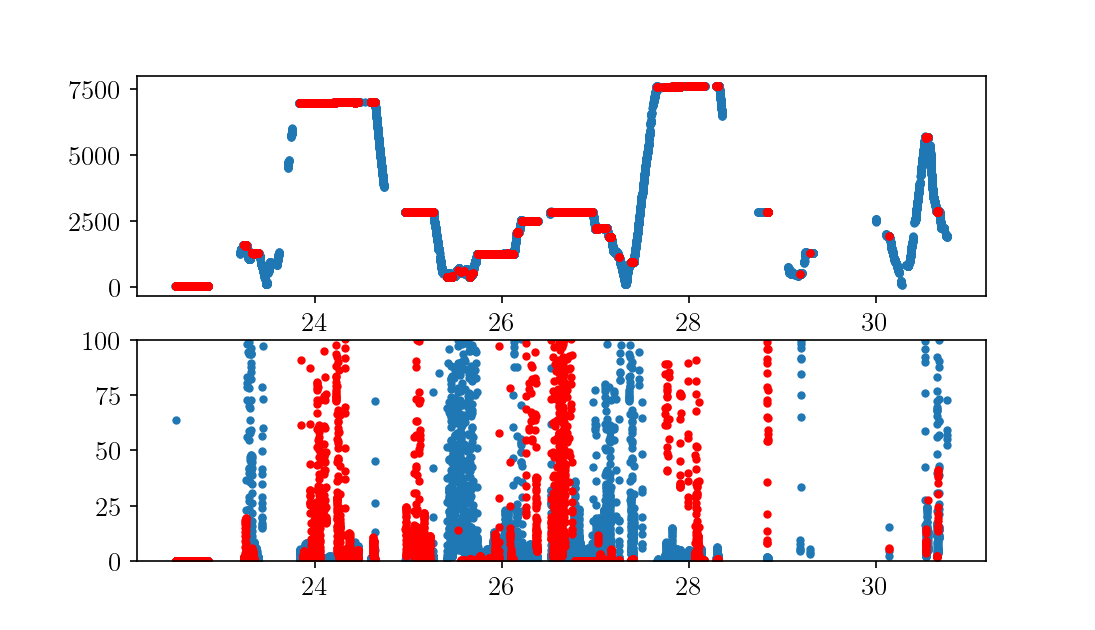

(0, 100)

In [151]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(ar['Start_UTC'][fl1],ar['GPS_Alt'][fl1],'.')
plt.plot(ar['Start_UTC'][fl1][f_level1],ar['GPS_Alt'][fl1][f_level1],'r.')


ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(ar['Start_UTC'][fl1],std_alt1,'.')
plt.plot(ar['Start_UTC'][fl1][f_level1],std_alt[f_level1],'r.')
plt.ylim(0,100)


<IPython.core.display.Javascript object>


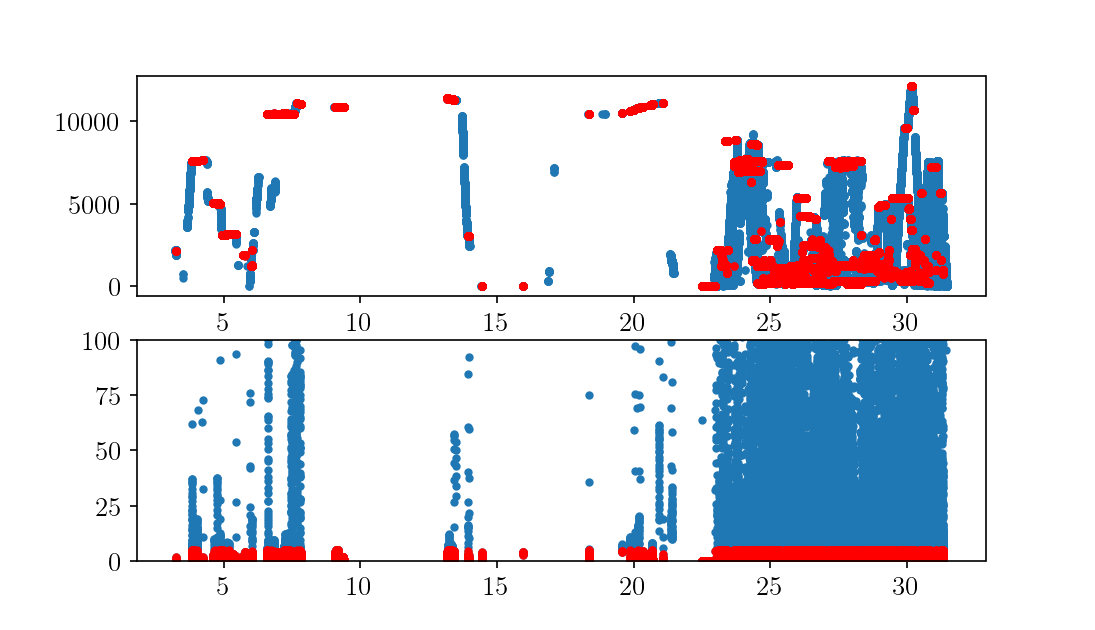

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


(0, 100)

In [152]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(ar['Start_UTC'][fl],ar['GPS_Alt'][fl],'.')
plt.plot(ar['Start_UTC'][fl][f_level],ar['GPS_Alt'][fl][f_level],'r.')


ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(ar['Start_UTC'][fl],std_alt,'.')
plt.plot(ar['Start_UTC'][fl][f_level],std_alt[[f_level]],'r.')
plt.ylim(0,100)

## Seperate each of the level legs into distinct segments

In [183]:
def get_segments(index,vals_dict,nsep=150,set_nan=True):
    'Function to seperate continuous segments (within a distance of nsep) based on a prior index'
    disc_flacaod_long = np.where(np.diff(index,1)>nsep)[0]
    
    discontinuity_istart_long =  index[np.append(0,disc_flacaod_long[:-1]+1)]
    discontinuity_iend_long =  index[disc_flacaod_long]
    
    kv = vals_dict.keys()
    d = {k:[] for k in kv}
    for i,start in enumerate(discontinuity_istart_long): # loop through discontinuities 
        if discontinuity_iend_long[i]-start < 2: continue
        for k in kv: # loop through keys
            try:
                d[k].append(vals_dict[k][start:discontinuity_iend_long[i]])
            except:
                print start, discontinuity_iend_long[i]
                continue
                #d[k].append([np.nan])
    
    for k in kv:
        d[k] = np.array(d[k])
        
    return d

In [324]:
ar['days']

array([ 0.,  0.,  0., ..., 19., 19., 19.])

In [592]:
angs[angs>5.0] = np.nan

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [593]:
vals = {'utc':ar['Start_UTC'][fl],'alt':ar['GPS_Alt'][fl],'lat':ar['Latitude'][fl],'lon':ar['Longitude'][fl],
        'aod0500':ar['AOD0501'][fl],'aod1040':ar['AOD1040'][fl],'AE':angs[fl],'doys':ar['doys'][fl],
        'aod_fine':fmf['tauf'][fl],'aod_coarse':fmf['tauc'][fl]}

In [594]:
dvals = get_segments(f_level,vals,nsep=100)

In [595]:
dvals.keys()

['aod1040',
 'utc',
 'AE',
 'doys',
 'aod0500',
 'lon',
 'aod_coarse',
 'lat',
 'alt',
 'aod_fine']

In [596]:
for n in dvals['utc']:
    try:
        print (n[-1]-n[0])*60.0
    except:
        print np.nan

45.416666666666785
3.9500000000000313
47.59999999999998
16.24999999999993
1.0999999999998522
65.78333333333333
1.0666666666668334
0.03333333333323196
1.6833333333332234
70.51666666666655
50.76666666666661
1.3000000000000966
0.8166666666666345
6.216666666666626
8.499999999999943
0.16666666666658614
34.33333333333337
3.583333333333414
0.6833333333334934
0.5833333333333712
4.1500000000000625
0.14999999999986358
78.46666666666678
1.8666666666667453
4.300000000000139
32.80000000000001
3.2166666666665833
1.9499999999999318
0.03333333333323196
0.03333333333323196
0.33333333333338544
0.7666666666666799
4.949999999999974
13.049999999999855
14.666666666666828
6.933333333333351
28.316666666666777
21.94999999999986
7.983333333333462
5.133333333333496
0.4166666666667851
37.88333333333334
0.8166666666666345
1.8833333333332547
1.1666666666667425
2.533333333333303
1.1166666666665748
16.116666666666575
227.64999999999992
5.3999999999999915
0.9833333333332206
0.40000000000006253
30.266666666666495
75.55

In [188]:
def discrete_matshow(data,cmapname='RdBu'):
    ' plotting function for a discrete colormap'
    cmap = plt.get_cmap(cmapname, np.nanmax(data)-np.nanmin(data)+1)
    # set limits .5 outside true range
    scalarmap = plt.cm.ScalarMappable(cmap=cmapname)
    scalarmap.set_array(data)
    #mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(scalarmap, ticks=np.arange(np.min(data),np.max(data)+1))
    return cax

In [ ]:
for q in np.unique(ar['days']):
    flq = ar['days'][fl]==q
    flql = ar['days'][fl][f_level]==q
    plt.figure()
    plt.plot(ar['Start_UTC'][fl][flq],ar['GPS_Alt'][fl][flq],'.')
    plt.plot(ar['Start_UTC'][fl][f_level][flql],ar['GPS_Alt'][fl][f_level][flql],'r.')
    ax = plt.gca()

    ax.set_color_cycle([plt.cm.gist_ncar(k) for k in np.linspace(0, 1, len(dvals['utc'])+1)])

    for i,n in enumerate(dvals['utc']):
        plt.plot(n,dvals['alt'][i],'s-',markeredgecolor='None')

    plt.xlabel('UTC [h from midnight]')
    plt.ylabel('Altitude [m]')
    plt.title('Days: {}'.format(q))

    #scalarmap = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('gist_ncar'))
    #scalarmap.set_array(range(len(dvals['utc'])+1))
    #cb = plt.colorbar(scalarmap)
    cb = discrete_matshow(range(len(dvals['utc'])+1),cmapname='gist_ncar')
    cb.set_label('Level leg number')
#plt.plot(ar['Start_UTC'][fl1][f_level],ar['GPS_Alt'][fl1][f_level],'r.')

## Now calculate the distances travelled within each segments

In [597]:
def get_distances(seg_dict):
    'Function that calculates the cumulative distance and instantaneous change between each point for a set of segments'
    seg_dict['dist'],seg_dict['cumdist'] = [],[]
    for i,l in enumerate(seg_dict['lat']):
        try:
            ckm,km = [],[]
            pos1 = [seg_dict['lat'][i][0],seg_dict['lon'][i][0]] 
            for j,a in enumerate(seg_dict['lat'][i]):
                d = mu.spherical_dist(pos1,[seg_dict['lat'][i][j],seg_dict['lon'][i][j]])
                ckm.append(d)
                km.append(d)
        except:
            cckm,dkm = [np.nan],[np.nan]

        iu = np.where(np.isfinite(ckm))[0]
        try:
            fckm = interpolate.interp1d(seg_dict['utc'][i][iu],np.array(ckm)[iu])
            fkm = interpolate.interp1d(seg_dict['utc'][i][iu],np.array(km)[iu])
            cckm = fckm(seg_dict['utc'][i])
            dkm = fkm(seg_dict['utc'][i])
            seg_dict['cumdist'].append(np.array(cckm))
            seg_dict['dist'].append(np.array(np.diff(dkm)))
        except:
            seg_dict['cumdist'].append(np.array(np.nan))
            seg_dict['dist'].append(np.array(np.nan))

    return seg_dict

In [598]:
ddv = get_distances(dvals)

In [599]:
dvals['cumdist']

[array([ 0.        ,  0.        ,  0.        , ..., 38.5748855 ,
        38.75314675, 38.90739789]),
 array([ 0.        ,  0.1064812 ,  0.21373213,  0.31441346,  0.42175507,
         1.29092221,  1.39738101,  1.50503797,  1.61236964,  1.7200196 ,
         1.82769429,  1.93934155,  2.1202961 ,  3.1529191 ,  3.29672172,
         3.45493055,  3.55008179,  3.563959  ,  3.78428911,  3.90356981,
         4.01799051,  4.13122304,  4.31221924,  4.47040009,  4.58397088,
         4.69838303,  4.81095067,  4.92060508,  5.04130839,  5.15416776,
         5.26850769,  5.382923  ,  5.49615015,  5.68162771,  5.84658886,
         5.96382811,  6.07823368,  6.19222737,  6.30533096,  6.42006961,
         6.53966053,  6.65429927,  6.768707  ,  6.88601739,  7.07596578,
         7.24190595,  7.35777671,  7.47083232,  7.5831651 ,  7.69371275,
         7.80552155,  7.9159888 ,  8.02797079,  8.13915292,  8.2491714 ,
         8.42506922,  8.57626882,  8.68379969,  8.7923609 ,  8.89742582,
         9.00285817,  9

In [600]:
dvals.keys()

['aod1040',
 'utc',
 'AE',
 'doys',
 'aod0500',
 'lon',
 'aod_coarse',
 'cumdist',
 'lat',
 'dist',
 'alt',
 'aod_fine']

## Calculate the autocorrelation of AOD with respect to distance

**From Shinozuka and Redemann, 2011, Horizontal variability of aerosol optical depth observed during the ARCTAS airborne experiment, ACP**

Autocorrelation is the correlation coefficient among all
data pairs xj and xj+k that exist at a separation, or lag, of k. That is,

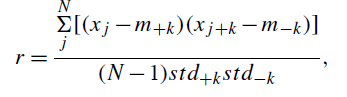

where k indicates the spatial lag (or distance), m+k and std+k denote the mean and standard deviation, respectively, of all data points that are located a distance of +k away from an- other data point, and m−k and std−k are the corresponding quantities for data points located a distance of −k away from another data point (Redemann et al., 2006; Anderson et al., 2003).
Figure 1c shows pairs of 499nm AOD measured 20km (±0.2 km) away from each other in the Canada phase. The correlation coefficient, r, is 0.37. This is the autocorrelation for 20km.

Define the different time periods from Met. From: 
    Peterson, D.A., Hyer, E.J., Han, S.-O., Crawford, J.H., Park, R.J., Holz, R., Kuehn, R.E., Eloranta, E., Knote, C., Jordan, C.E. and Lefer, B.L., 2019. Meteorology influencing springtime air quality, pollution transport, and visibility in Korea. Elem Sci Anth, 7(1), p.57. DOI: http://doi.org/10.1525/elementa.395

    - Dynamic meteorology and complex aerosol vertical profiles (01–16 May);
    - Stagnation under a persistent anticyclone (17–22 May);
    - Dynamic meteorology, low-level transport, and haze development (25–31 May); (Extreme pollution)
    - Blocking pattern (01–07 June).


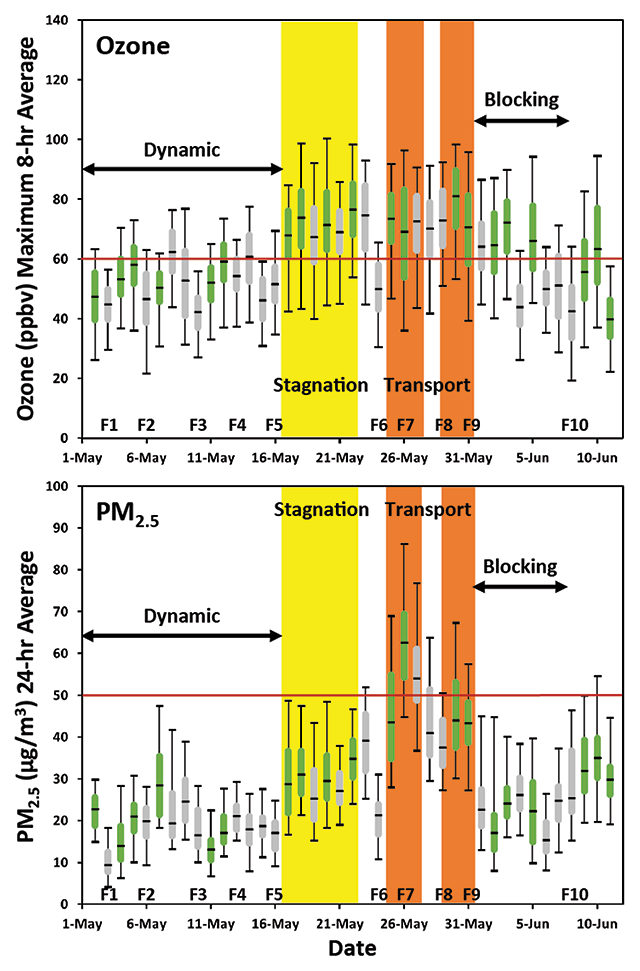

The distribution and source of pm 2.5 during different met periods

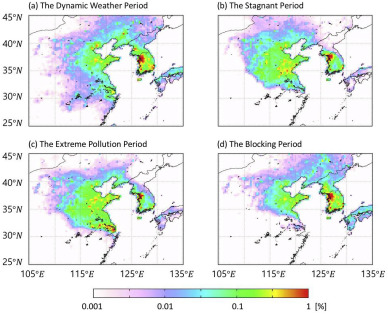

### Build the limits of the autocorrelation

In [601]:
# for met times
dt1 = ['20160501','20160516']
dt2 = ['20160517','20160522']
dt3 = ['20160523','20160531']
dt4 = ['20160601','20160607']

In [602]:
t1 = [datetime(int(d[0:4]),int(d[4:6]),int(d[6:8])).timetuple().tm_yday for d in dt1]
t2 = [datetime(int(d[0:4]),int(d[4:6]),int(d[6:8])).timetuple().tm_yday for d in dt2]
t3 = [datetime(int(d[0:4]),int(d[4:6]),int(d[6:8])).timetuple().tm_yday for d in dt3]
t4 = [datetime(int(d[0:4]),int(d[4:6]),int(d[6:8])).timetuple().tm_yday for d in dt4]

In [603]:
# limits of DOY for each of the met times
t1,t2,t3,t4

([122, 137], [138, 143], [144, 152], [153, 159])

In [604]:
#altitude limits in m
z1 = [0.0, 1000.0] 
z2 = [1000.0, 3000.0]
z3 = [3000.0, 15000.0]

### Test out Shinozuka & Redemann autocorrelation 

In [263]:
dvals['cumdist'][2]

array([0.00000000e+00, 1.52460168e-01, 3.09808070e-01, 5.86067543e-01,
       8.01333704e-01, 9.58783600e-01, 1.11269273e+00, 1.26962440e+00,
       1.42901633e+00, 1.59074522e+00, 1.74891958e+00, 1.90509668e+00,
       2.05719335e+00, 2.21461958e+00, 2.49567172e+00, 2.70895078e+00,
       2.86607779e+00, 3.02323546e+00, 3.17925213e+00, 3.33229874e+00,
       3.48882108e+00, 3.64740691e+00, 3.80978181e+00, 3.96830128e+00,
       4.12664572e+00, 4.39813014e+00, 4.60713051e+00, 4.76547290e+00,
       4.92281956e+00, 5.07747719e+00, 5.23053325e+00, 5.38707156e+00,
       9.84031460e+00, 9.99229133e+00, 1.01544060e+01, 1.03078527e+01,
       1.05779269e+01, 1.07869382e+01, 1.09452684e+01, 1.10996880e+01,
       1.12518143e+01, 1.14084631e+01, 1.15659591e+01, 1.17182202e+01,
       1.18744478e+01, 1.20326668e+01, 1.21855679e+01, 1.24556709e+01,
       1.26647360e+01, 1.28218881e+01, 1.29761861e+01, 1.31304926e+01,
       1.32866292e+01, 1.34379129e+01, 1.35958848e+01, 1.37479094e+01,
      

In [363]:
dvals.keys()

['aod1040',
 'utc',
 'AE',
 'doys',
 'aod0500',
 'lon',
 'aod_coarse',
 'cumdist',
 'lat',
 'dist',
 'alt',
 'aod_fine']

In [ ]:
# method for making one autocorrelation per segment. Old not recommended
if False:
    cr = []
    for i,cd in enumerate(dvals['cumdist']):
        #cd = dvals['cumdist'][i]
        corr = {'aod1040':[],'aod0500':[],'AE':[]}
        corr_ks =[0.1,0.25,0.5,0.75,1.0,1.5,2.0,3.0,5.0,7.5,10.0,12.5,15.0,20.0,
                  25.0,30.0,35.0,40.0,50.0,60.0,75.0,100.0,150.0,200.0] 
        for ik, k in enumerate(corr_ks):

        #k = 5.0 # for 5km distance
            if k>np.nanmax(cd):
                [corr[val].append(np.nan) for val in corr.keys()]
                continue
            ipk = np.argmin(abs(cd-k)) #ipk:
            imk = np.argmin(abs(cd-(cd[-1]-k))) #0:imk
            N = len(cd)
            #c = np.sqrt(2.0/(N-1))*math.gamma(N/2.0)/math.gamma((N-1.0)/2.0)

            for val in dvals.keys():
                if val in ['lon','utc','lat','cumdist','cdist_n','dist','alt','autocor','aod1040_r','AE_r','aod_n']: continue
                #print val, len(dvals[val][i])
                mpk = np.nanmean(dvals[val][i][ipk:]) #mean +k
                mmk = np.nanmean(dvals[val][i][0:imk]) #mean -k
                spk = np.nanstd(dvals[val][i][ipk:]) #std +k
                smk = np.nanstd(dvals[val][i][0:imk]) #std -k
                top = [(dvals[val][i][j]-mpk)*(dvals[val][i][j+ipk]-mmk) for j in xrange(N-ipk-1)]
                #dvals[val+'_r'] = []
                corr[val].append(np.sum(top)/((N-1)*spk*smk))
                if (corr[val][-1]>1.0) | (corr[val][-1]<0.0):
                    print '{} has bad corr: {:2.2f} val for key {}: std+k:{:2.2f}, std-k:{:2.2f}, m+k:{:2.2f}, m-k:{:2.2f} '.format(i,
                        corr[val][-1],val,spk,smk,mpk,mmk)

        for val in corr.keys():
            corr[val] = np.array(corr[val])
        cr.append(corr)

In [316]:
len(cr)

166

<IPython.core.display.Javascript object>


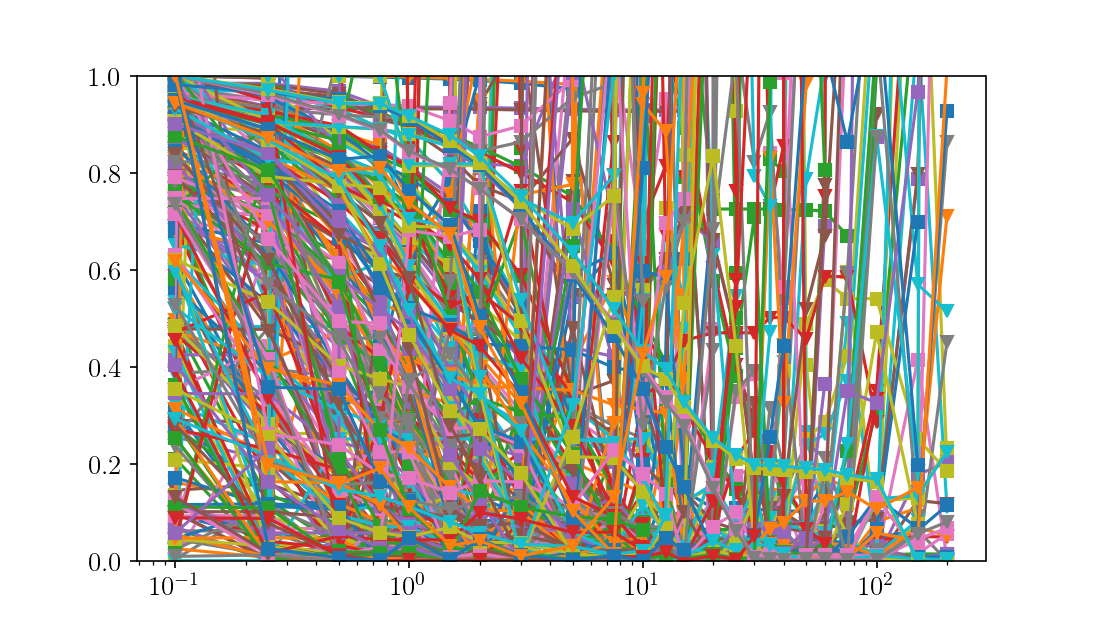

(0, 1)

In [321]:
plt.figure()
for corr in cr:
   # plt.plot(corr_ks,corr['AE']**2.0,'x-')
    plt.plot(corr_ks,corr['aod1040']**2.0,'s-')
    plt.plot(corr_ks,corr['aod0500']**2.0,'v-')
plt.xscale('log')
plt.ylim(0,1)

In [605]:
types = ['all','t1','t2','t3','t4','z1','z2','z3']

In [606]:
corr_ks =[0.1,0.25,0.5,0.75,1.0,1.5,2.0,3.0,5.0,7.5,10.0,12.5,15.0,20.0,
          25.0,30.0,35.0,40.0,50.0,60.0,75.0,100.0,150.0,200.0] 
corr_all = [[[{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)],
             [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]] \
            for j in types] 
#corr_all = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_t1 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_t2 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_t3 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_t4 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_z1 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_z2 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
#corr_z3 = [{'k':k,'aod1040':[],'aod0500':[],'AE':[],'aod_fine':[],'aod_coarse':[]} for i,k in enumerate(corr_ks)]
corr_vals = corr_all[0][0][0].keys()
corr_vals.remove('k')

In [607]:
corr_all[0][0][0]

{'AE': [],
 'aod0500': [],
 'aod1040': [],
 'aod_coarse': [],
 'aod_fine': [],
 'k': 0.1}

In [608]:
np.array(corr_all).shape #type, [minusk,plusk], distance

(8, 2, 24)

In [609]:
for ik, k in enumerate(corr_ks):
    for i,cd in enumerate(dvals['cumdist']):
        if k>np.nanmax(cd):
            continue
        ipk = np.argmin(abs(cd-k)) #ipk:
        imk = np.argmin(abs(cd-(cd[-1]-k))) #0:imk
        if imk<2:
            continue
        iip = Sp.find_closest(cd,cd[0:imk]+k)
        N = len(cd)
        for val in corr_vals:
            #all
            corr_all[0][0][ik][val] = np.append(corr_all[0][0][ik][val],dvals[val][i][0:imk])
            corr_all[0][1][ik][val] = np.append(corr_all[0][1][ik][val],dvals[val][i][iip])
            #type 1
            if (dvals['doys'][i][0]> t1[0]) & (dvals['doys'][i][0]< t1[1]):
                corr_all[1][0][ik][val] = np.append(corr_all[1][0][ik][val],dvals[val][i][0:imk])
                corr_all[1][1][ik][val] = np.append(corr_all[1][1][ik][val],dvals[val][i][iip])
            #type 2
            if (dvals['doys'][i][0]> t2[0]) & (dvals['doys'][i][0]< t2[1]):
                corr_all[2][0][ik][val] = np.append(corr_all[2][0][ik][val],dvals[val][i][0:imk])
                corr_all[2][1][ik][val] = np.append(corr_all[2][1][ik][val],dvals[val][i][iip])
            #type 3
            if (dvals['doys'][i][0]> t3[0]) & (dvals['doys'][i][0]< t3[1]):
                corr_all[3][0][ik][val] = np.append(corr_all[3][0][ik][val],dvals[val][i][0:imk])
                corr_all[3][1][ik][val] = np.append(corr_all[3][1][ik][val],dvals[val][i][iip])
            #type 4
            if (dvals['doys'][i][0]> t4[0]) & (dvals['doys'][i][0]< t4[1]):
                corr_all[4][0][ik][val] = np.append(corr_all[4][0][ik][val],dvals[val][i][0:imk])
                corr_all[4][1][ik][val] = np.append(corr_all[4][1][ik][val],dvals[val][i][iip])
            #type 5
            if (dvals['alt'][i][0]> z1[0]) & (dvals['alt'][i][0]< z1[1]):
                corr_all[5][0][ik][val] = np.append(corr_all[5][0][ik][val],dvals[val][i][0:imk])
                corr_all[5][1][ik][val] = np.append(corr_all[5][1][ik][val],dvals[val][i][iip])
            #type 6
            if (dvals['alt'][i][0]> z2[0]) & (dvals['alt'][i][0]< z2[1]):
                corr_all[6][0][ik][val] = np.append(corr_all[6][0][ik][val],dvals[val][i][0:imk])
                corr_all[6][1][ik][val] = np.append(corr_all[6][1][ik][val],dvals[val][i][iip])
            #type 7
            if (dvals['alt'][i][0]> z3[0]) & (dvals['alt'][i][0]< z3[1]):
                corr_all[7][0][ik][val] = np.append(corr_all[7][0][ik][val],dvals[val][i][0:imk])
                corr_all[7][1][ik][val] = np.append(corr_all[7][1][ik][val],dvals[val][i][iip])

In [610]:
autocorr = {}
for val in corr_vals:
    autocorr[val] = np.zeros((len(types),len(corr_ks)))+np.nan
    
    for ik,k in enumerate(corr_ks):
        for j,jt in enumerate(types):
            if False: #val is 'AE':
                igd = np.where(corr_all[2][1][3]['AE']<5.0)[0] #np.isfinite(corr_all[j][0][ik][val])
                mmk = np.nanmean(corr_all[j][0][ik][val][igd])
                mpk = np.nanmean(corr_all[j][1][ik][val][igd])
                smk = np.nanstd(corr_all[j][0][ik][val][igd])
                spk = np.nanstd(corr_all[j][1][ik][val][igd])
                top = [(v-mpk)*(corr_all[j][1][ik][val][igd][iv]-mmk) for iv,v in enumerate(corr_all[j][0][ik][val][igd])]
                print val,ik,j,mmk,mpk,smk,spk,np.nansum(top)
                autocorr[val][j,ik] = np.nansum(top)/((len(corr_all[j][0][ik][val][igd])-1)*spk*smk)
            else:
                mmk = np.nanmean(corr_all[j][0][ik][val])
                mpk = np.nanmean(corr_all[j][1][ik][val])
                smk = np.nanstd(corr_all[j][0][ik][val])
                spk = np.nanstd(corr_all[j][1][ik][val])
                top = [(v-mpk)*(corr_all[j][1][ik][val][iv]-mmk) for iv,v in enumerate(corr_all[j][0][ik][val])]
                print val,ik,j,mmk,mpk,smk,spk,np.nansum(top)
                autocorr[val][j,ik] = np.nansum(top)/((len(corr_all[j][0][ik][val])-1)*spk*smk)

aod1040 0 0 0.3104036643699106 0.3471556858948807 0.3306270728983134 0.4050869843447557 5913.458373989393
aod1040 0 1 0.37207693190512625 0.46356457536342777 0.3513946369913343 0.496365275310355 2318.383154647781
aod1040 0 2 0.25493854366274293 0.26768614837120175 0.2852708212797055 0.29002940875695893 550.9822706637011
aod1040 0 3 0.329660394265233 0.3331209677419355 0.29174490546550685 0.29833022865771264 84.13267611200718
aod1040 0 4 0.30142381252627154 0.30620765027322405 0.3287753947128142 0.3348610290133772 921.4327039006935
aod1040 0 5 0.3521077998261878 0.44323761587485516 0.3461787354909865 0.500558694333868 2038.184691227006
aod1040 0 6 0.344447322257765 0.32910138272624084 0.34779427406045776 0.3312881784426995 1745.2568024872048
aod1040 0 7 0.23247474834380114 0.2480646562849522 0.2792741059787122 0.2926263531559826 1707.0891760456423
aod1040 1 0 0.31403900491400494 0.35116135778635776 0.3338760624741137 0.40826891179689423 5695.984223054655
aod1040 1 1 0.37270806091839087 

aod1040 10 6 0.3649009671993272 0.3342212643678161 0.35508259828193917 0.34617141467302714 662.5874048884917
aod1040 10 7 0.20249017986355178 0.23418353318172422 0.24496677289570606 0.32677491917530904 859.6445790365412
aod1040 11 0 0.3024615214150449 0.33825571135017535 0.3250580988651349 0.38765177316909377 2664.935758353056
aod1040 11 1 0.3566738749269433 0.4090457334891876 0.338680877256531 0.3888943205058857 1058.4593710913207
aod1040 11 2 0.2506084013192154 0.25243100156222875 0.2718370686060261 0.3330741081778486 203.15941803697274
aod1040 11 3 0.3384548802946593 0.47309023941068146 0.29577213818208353 0.47183567421196404 19.50136451197052
aod1040 11 4 0.3108182692307692 0.33561266025641023 0.3259755535699104 0.37854427746298625 181.9172569604167
aod1040 11 5 0.37573588307256456 0.4632724228961432 0.3610197772195394 0.46211397792433667 849.9095994923701
aod1040 11 6 0.3649058823529412 0.3335546218487395 0.354737370500631 0.3406304849103884 591.1882238436975
aod1040 11 7 0.204891

aod1040 20 5 0.27814975728155344 0.39831031553398055 0.289208721954076 0.5103295764906857 76.41153165206319
aod1040 20 6 0.3485135319148936 0.3651822978723404 0.3733427648015336 0.39254228486340625 73.41219942587233
aod1040 20 7 0.16570472500759648 0.16862032816773015 0.21461174678605446 0.26341082036552965 256.2573214506989
aod1040 21 0 0.21063091989083318 0.2702995665435865 0.2625291698383753 0.4090359843682215 454.09023437052497
aod1040 21 1 0.2551985872531707 0.36953138545512926 0.27880395460458857 0.4304674392621503 103.85629278551936
aod1040 21 2 0.19106666666666666 0.20507670250896057 0.209542753270135 0.32633666104032405 -26.684494547670248
aod1040 21 3 0.24245454545454548 0.06699999999999999 0.34565822942647834 1.3877787807814457e-17 -0.6772545454545456
aod1040 21 4 0.20132823995472554 0.12425863044708547 0.2535055117624849 0.21315101523282814 -1.55099156762875
aod1040 21 5 0.282028901734104 0.5157718139278833 0.3077239612445904 0.6235449435916453 -41.63824416047345
aod1040 21

AE 7 0 0.3900146210653142 0.3741054248949692 0.461946144510473 0.4539933504702102 9564.210260775266
AE 7 1 0.24768535667896838 0.2106737485312078 0.3397655728207867 0.3018106504964247 1579.099054685016
AE 7 2 0.36844148455073605 0.36871353158358183 0.4405143162516985 0.45191906005174076 1227.1187512272377
AE 7 3 0.28371050918507035 0.3037487300089479 0.40550193381527694 0.4321224738008137 129.3047028045188
AE 7 4 0.5819411579963303 0.5991340580796948 0.4634179112917707 0.451850452851241 1119.7611768885147
AE 7 5 0.7596832971456453 0.691392091218988 0.46956906231141815 0.4857362028038894 2709.4164503072566
AE 7 6 0.3598719979313569 0.38589461372244105 0.3767426314132434 0.38260990229045766 1866.1167734395851
AE 7 7 0.09658184849888489 0.08936859380449795 0.24109251119539948 0.23960498517022386 892.0833457854781
AE 8 0 0.4687468615957187 0.46890508227592553 0.49602477596529154 0.5013878245266709 11542.385413555647
AE 8 1 0.24864092182706213 0.21359511732757633 0.3490365994357247 0.317536

AE 17 3 0.403908909783653 0.36567298674840387 0.4882032502307086 0.5486436321690848 33.9373740521671
AE 17 4 0.5051591934338273 0.4472469321102401 0.4687402505564779 0.4369091021124323 334.7825250574983
AE 17 5 0.8773241897686537 0.8400261534062964 0.48114634894512737 0.5068070875859987 1573.8547706825498
AE 17 6 0.37346016945355925 0.41344368992248287 0.3658926450912178 0.3946366621750288 714.1205759510002
AE 17 7 0.07123083225172454 0.0925740703992308 0.2194703469015113 0.27141550624790994 632.78886547219
AE 18 0 0.44622687824862656 0.4540240712089102 0.5136777140464402 0.5180346344919902 6772.9317408534025
AE 18 1 0.18643330513866407 0.2003986035362594 0.2873647755335285 0.34283435213235264 532.5513433127348
AE 18 2 0.39757524235694247 0.3757038158825759 0.4892679132254885 0.490671013938336 591.826978691029
AE 18 3 0.598088264230313 1.0623673267135303 0.5164279385927714 0.3519510076270081 -5.502265316071245
AE 18 4 0.47658679878446353 0.4528699806214793 0.4904240928304486 0.48252856

aod_coarse 3 7 0.2131306993395211 0.26669041682029476 0.33213370388757113 0.6827238737368646 1262.6061360512902
aod_coarse 4 0 0.2762416230009913 0.32491313631056473 0.39592822466116223 0.5603527931283802 3942.599936998503
aod_coarse 4 1 0.3360275795908511 0.4135220506940026 0.3739675559007212 0.4769364491369903 1700.4739255258178
aod_coarse 4 2 0.21934462196452867 0.23246038639653904 0.31640979429428906 0.3006886542700999 369.6575848649704
aod_coarse 4 3 0.29759266566456405 0.30880604438160375 0.5426702349093023 0.556192322783789 69.5712891994907
aod_coarse 4 4 0.28344741080538927 0.3109498426371831 0.41957086022349904 0.5016355042378299 484.63655377940324
aod_coarse 4 5 0.3000778428118638 0.3909301752793057 0.41991687328325145 0.5305788971618618 1408.607995809542
aod_coarse 4 6 0.32076949705995966 0.3067389612102168 0.42317725008404844 0.41616020097059636 1078.9870852378751
aod_coarse 4 7 0.21277637985120354 0.2661803816603596 0.33193974721487995 0.6774996613470685 1259.6848991632446

aod_coarse 14 5 0.29524139903819147 0.40631978898472754 0.40058122563951126 0.5703194564834344 704.5050018931946
aod_coarse 14 6 0.32017451991209817 0.38837682780666694 0.4005139730405114 0.9238728891419943 175.78308740967725
aod_coarse 14 7 0.17508987421492636 0.1844600061221816 0.2853583335011086 0.29136251017350195 462.49331277565227
aod_coarse 15 0 0.25855423770946095 0.3223743944192854 0.39327655621481866 0.6644753311893111 1239.7631783340282
aod_coarse 15 1 0.31121333093618225 0.44668912354525947 0.37270894240399477 0.8473996596588587 223.31108058623568
aod_coarse 15 2 0.20029053185844037 0.19511300719303687 0.2566453531654369 0.3220505976428021 43.30702137680287
aod_coarse 15 3 0.40422231454412033 0.46125246346894916 0.8164458187875174 0.53324056989577 43.85233688125694
aod_coarse 15 4 0.2416084292994372 0.27250188388617697 0.4115363548487161 0.4640866162079075 33.19069869292045
aod_coarse 15 5 0.30953246889958547 0.42049596376168324 0.4479050490872385 0.5403720766040663 554.971

aod_coarse 23 7 0.11765336805219961 0.15389803283889392 0.2961088293933152 0.3595039374537059 51.10461225256459
aod0500 0 0 0.40026160241444103 0.44413383349467567 0.38588310156950884 0.48539182578970913 8192.519837949647
aod0500 0 1 0.4122242157612854 0.49861430757459824 0.36567758536354855 0.5320066799176559 2870.7253657770852
aod0500 0 2 0.3029511360525595 0.31505091705447574 0.3200259813474795 0.3127835208919024 610.325323437038
aod0500 0 3 0.4664256272401433 0.47087813620071683 0.48577643834682016 0.5096265635278022 250.49919036827959
aod0500 0 4 0.4137617696511139 0.4101810634720471 0.4031915339966477 0.3860935263909785 1248.9899224885457
aod0500 0 5 0.5323692424681344 0.6286142815758979 0.40260666800495326 0.5338189652124455 2923.6204649911288
aod0500 0 6 0.3983403673511505 0.3823370653183366 0.3809997361783057 0.3641097371378331 1862.3868771687648
aod0500 0 7 0.2449210186698787 0.2764978060741633 0.3024829096839632 0.4372137552981488 1977.0840384064354
aod0500 1 0 0.40302465777

aod0500 9 3 0.44480668604651163 0.4600959302325581 0.4958375333030376 0.4256990107742026 67.7709801991279
aod0500 9 4 0.43042677473448854 0.44345584125209614 0.3938886014906847 0.4382091733771605 373.44953681498043
aod0500 9 5 0.551548988406456 0.63835280745624 0.42175970092801907 0.4973483789862056 1552.7029656633326
aod0500 9 6 0.4131139163805292 0.4029485625799502 0.3826139692804661 0.4438462997296865 884.4404019231805
aod0500 9 7 0.23779570835256117 0.27091241347485007 0.30138178261553655 0.42984160838077895 1086.7811041071989
aod0500 10 0 0.38781093253597454 0.4301657260325173 0.38420786817693 0.49172302212390545 4523.898692895739
aod0500 10 1 0.40501512997562955 0.4492548740861088 0.3654597557005717 0.4360438501612059 1386.296864975833
aod0500 10 2 0.302336478960396 0.31362592821782176 0.2992550691374065 0.323979698775736 314.8682820465656
aod0500 10 3 0.44743485342019546 0.49633876221498363 0.514929486482453 0.466878081054521 69.19923888110749
aod0500 10 4 0.4271257194789458 0.4

aod0500 19 0 0.29938298246849254 0.36275765683306344 0.326537465779271 0.5414028700717677 1291.974903792051
aod0500 19 1 0.29308066149173134 0.44581268984137695 0.28582034530500106 0.6429482111312997 128.13339299291258
aod0500 19 2 0.23593405979323834 0.2564579491478067 0.23393270826722157 0.30360542363578363 24.063186783459066
aod0500 19 3 0.7497045454545455 0.5268409090909091 0.7338873328052924 0.5346729647509187 8.38926111363636
aod0500 19 4 0.2489478448275862 0.20427974137931035 0.33952291114684896 0.38951172100013226 20.58588228836207
aod0500 19 5 0.45611144815189303 0.5432219975283676 0.3427786186123035 0.5675065378688255 311.38863299786544
aod0500 19 6 0.3658781536161465 0.5623238646981872 0.3720194684060732 0.7977121490383099 -81.00464686114742
aod0500 19 7 0.17568256323300832 0.17382224106259717 0.23528349511107516 0.271883154460032 248.02493518602517
aod0500 20 0 0.3159459657612082 0.3528004325671762 0.3637595755298746 0.47496549055735143 1256.7378520708235
aod0500 20 1 0.288

aod_fine 5 0 0.12826789995575102 0.1340638687319789 0.20152516821223615 0.26524741696205323 1443.7998194404972
aod_fine 5 1 0.08382795109808273 0.09744164617454185 0.1204790166718637 0.17922597413409502 280.4133470343183
aod_fine 5 2 0.08602514385698498 0.08905185273010419 0.12418841947704376 0.09605323780230948 42.58085476392567
aod_fine 5 3 0.12443377735019602 0.12237148039207052 0.343133009800707 0.23660701719155033 47.137047442776925
aod_fine 5 4 0.16580766404616484 0.16509509465199068 0.19012421673446758 0.207970466911325 93.41521025485557
aod_fine 5 5 0.23630764549750632 0.26621236997161973 0.2427271410587153 0.27971018249397167 773.455222833921
aod_fine 5 6 0.0960263684011641 0.09807806661002888 0.16423478933216917 0.16306796670454018 105.93779724780529
aod_fine 5 7 0.03936713820989656 0.02154101341283031 0.10396460039223494 0.25119799434904616 -54.56688827041863
aod_fine 6 0 0.12688181029285783 0.1314731686733276 0.20900199243973194 0.2741628237217829 1351.1625167875395
aod_fin

aod_fine 15 7 0.02849184569761432 0.028381342506012267 0.08242689314456367 0.060216260973789605 12.778451910387727
aod_fine 16 0 0.10663092457029286 0.08358104708892089 0.20616949171564758 0.2882950929542096 519.9012897840062
aod_fine 16 1 0.05922313536183978 0.014743370573194725 0.11748490665306337 0.38013666617892927 -32.38440215635086
aod_fine 16 2 0.08206693331642916 0.07341454148832752 0.09475003914986489 0.07944803119754561 19.036733435303166
aod_fine 16 3 0.19070633287357275 0.16667867408848433 0.5604706182978525 0.3230207262254082 29.28146804348317
aod_fine 16 4 0.11458077057489663 0.11571380070924993 0.17156514454543706 0.21356962915192285 21.440455325186825
aod_fine 16 5 0.23246534212571576 0.20226233802602114 0.28525454932115674 0.2194177867714437 241.73926411421428
aod_fine 16 6 0.09884535962961973 0.048734334036638766 0.17877441712069184 0.45601909408501307 20.992290241387742
aod_fine 16 7 0.027458798993375274 0.02629187258788181 0.08186094902220743 0.08774857109818769 10.

<IPython.core.display.Javascript object>


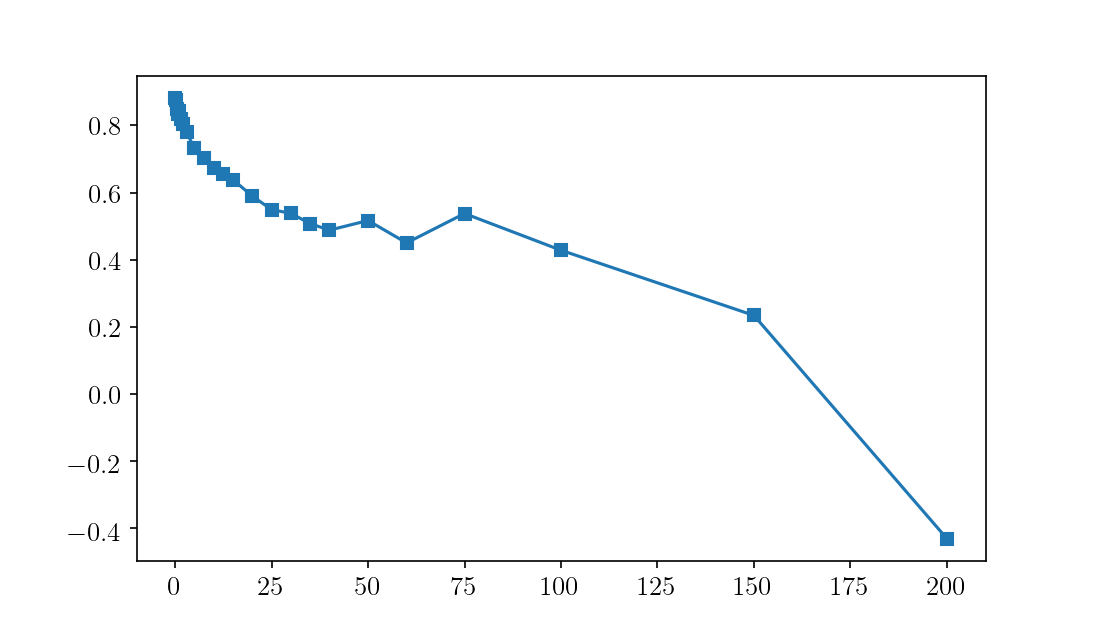

In [618]:
plt.figure()
plt.plot(corr_ks,autocorr['AE'][6,:],'s-')

### Integrated autocorrelation

In [193]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

In [194]:
def autocorr2(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]/result.max()

In [195]:
def autocorr5(x):
    '''numpy.correlate, non partial'''
    n = len(x)
    lags = range(n)
    #mean=x.mean()
    var=np.nanvar(x)
    xp=x-np.nanmean(x)
    corr=np.correlate(xp,xp,'full')[n-1:]/var/n

    return corr[:n]

In [196]:
authcor = autocorr(dvals['aod0500'][1])
authcor2 = autocorr2(dvals['aod0500'][1])
authcor3 = autocorr5(dvals['aod0500'][1])

In [197]:
len(authcor2)

150

In [198]:
len(dvals['aod0500'][1])

150

In [199]:
dvals['dist'][1]

array([ 1.06481196e-01,  1.07250931e-01,  1.00681330e-01,  1.07341610e-01,
        8.69167146e-01,  1.06458801e-01,  1.07656959e-01,  1.07331664e-01,
        1.07649960e-01,  1.07674690e-01,  1.11647259e-01,  1.80954556e-01,
        1.03262300e+00,  1.43802620e-01,  1.58208826e-01,  9.51512382e-02,
        1.38772160e-02,  2.20330108e-01,  1.19280697e-01,  1.14420705e-01,
        1.13232525e-01,  1.80996198e-01,  1.58180858e-01,  1.13570789e-01,
        1.14412142e-01,  1.12567644e-01,  1.09654413e-01,  1.20703305e-01,
        1.12859373e-01,  1.14339927e-01,  1.14415309e-01,  1.13227154e-01,
        1.85477559e-01,  1.64961149e-01,  1.17239249e-01,  1.14405573e-01,
        1.13993694e-01,  1.13103587e-01,  1.14738645e-01,  1.19590922e-01,
        1.14638736e-01,  1.14407733e-01,  1.17310389e-01,  1.89948391e-01,
        1.65940173e-01,  1.15870761e-01,  1.13055610e-01,  1.12332776e-01,
        1.10547653e-01,  1.11808799e-01,  1.10467251e-01,  1.11981989e-01,
        1.11182131e-01,  

In [200]:
[(dvals['dist'][i].mean(),np.size(dvals['dist'][i])) for i in xrange(len(dvals['dist']))]

[(0.027810863396092143, 1399),
 (0.07922729735734811, 149),
 (0.5092342094481336, 859),
 (0.3091444650740662, 376),
 (0.1165757481628561, 66),
 (0.09733106184325929, 939),
 (0.11255256410449042, 64),
 (0.12107382384126608, 2),
 (0.12647841840014587, 99),
 (0.1958055922118615, 1171),
 (0.8661174565074323, 106),
 (0.15142106162476907, 78),
 (0.13978965343665184, 49),
 (0.17584446141423019, 329),
 (0.05805132406036755, 27),
 (0.08803829684509726, 10),
 (0.24752162640782457, 1666),
 (0.1499244128630026, 215),
 (0.1344330978692005, 41),
 (0.13342682762009722, 35),
 (0.13463467852772917, 219),
 (0.10611934608691116, 9),
 (0.02329074636928539, 2860),
 (0.228787625962917, 90),
 (0.10799369369205011, 258),
 (0.06520551339862435, 1467),
 (0.12132977368120482, 166),
 (0.10525581107680525, 117),
 (0.10691224620045008, 2),
 (0.10986877128049924, 2),
 (0.1191751022725345, 20),
 (0.11169653958040217, 46),
 (0.086904815526222, 288),
 (0.12407996157738535, 783),
 (0.13069215698254336, 875),
 (0.1158100

### interpolate AODs to a constant distance grid

In [204]:
def interp_dist(d,dist=0.12,verbose=False):
    'function to insterpolate the AOD from the dict to an even grid spacing accroding to distance (default 0.12 km)'
    d['cdist_n'],d['aod_n'] = [],[]
    for i,cd in enumerate(d['cumdist']):
        if verbose:
            print i, cd.min(),cd.max(), np.nanmin(cd),np.nanmax(cd)
            if not np.isfinite(cd.min()): print cd
        d['cdist_n'].append(np.arange(cd.min(),cd.max(),dist))
        try:
            fcd = interpolate.interp1d(cd,d['aod0500'][i])
            d['aod_n'].append(fcd(d['cdist_n'][i]))
        except TypeError:
            d['aod_n'].append(np.array(np.nan))

In [202]:
dvals['aod0500']

array([array([0.561, 0.561, 0.56 , ..., 0.463, 0.439, 0.446]),
       array([0.229, 0.225, 0.22 , 0.218, 0.216, 0.218, 0.218, 0.222, 0.221,
       0.234, 0.294, 0.317, 0.514, 0.59 , 0.59 , 1.608, 0.272, 0.267,
       0.244, 0.241, 0.253, 0.248, 0.262, 0.352, 0.352, 0.536, 0.747,
       0.391, 0.955, 0.571, 0.334, 0.336, 0.425, 0.527, 0.409, 0.409,
       0.399, 1.51 , 0.764, 0.387, 0.348, 0.318, 0.274, 0.278, 0.309,
       0.304, 0.304, 0.267, 0.265, 0.268, 0.271, 0.276, 0.278, 0.28 ,
       0.282, 0.31 , 0.378, 0.378, 0.347, 0.496, 0.384, 0.352, 0.343,
       0.338, 0.339, 0.342, 0.592, 0.592, 1.175, 2.039, 2.039, 2.662,
       1.33 , 0.672, 0.785, 0.922, 0.935, 0.379, 0.379, 0.366, 0.352,
       0.339, 0.351, 0.341, 0.325, 0.332, 0.328, 0.32 , 0.328, 0.328,
       0.349, 0.33 , 0.341, 0.324, 0.309, 0.313, 0.318, 0.332, 0.324,
       0.307, 0.307, 0.28 , 0.27 , 0.264, 0.261, 0.267, 0.257, 0.255,
       0.259, 0.259, 0.25 , 0.247, 0.246, 0.252, 0.255, 0.251, 0.246,
       0.25 , 0.238,

In [205]:
interp_dist(dvals)

In [206]:
dvals['autocor'] = [] 
for i,a in enumerate(dvals['aod_n']):
    try:
        dvals['autocor'].append(autocorr5(a))
    except:
        dvals['autocor'].append(np.array(np.nan))

/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice.
  
/home/sam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


### Autocorrelation plots (old)

<IPython.core.display.Javascript object>


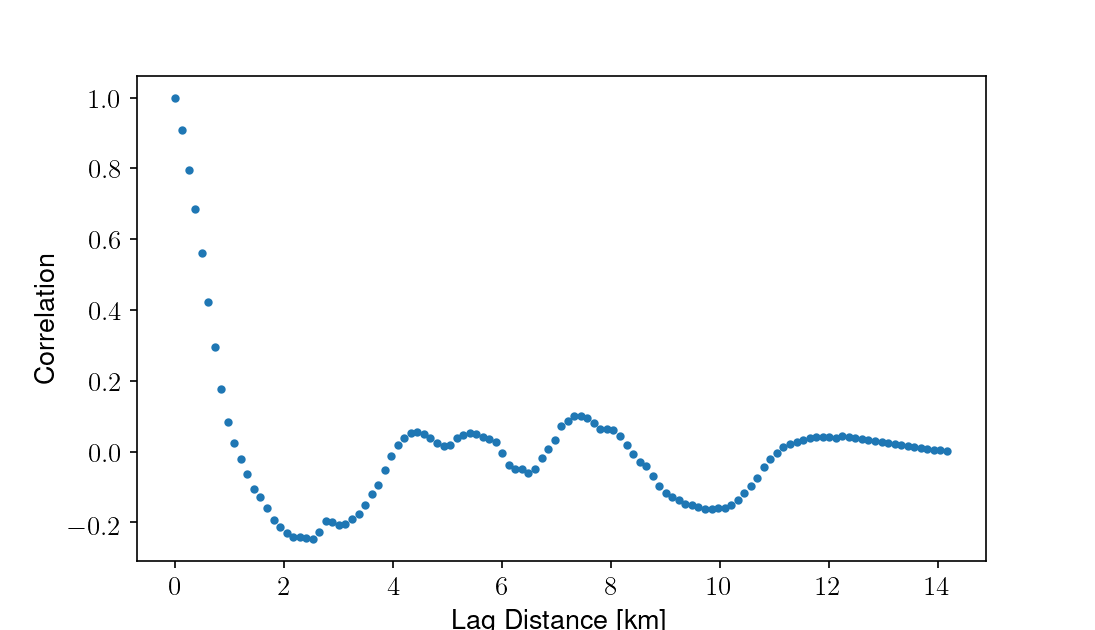

Text(0,0.5,'Correlation')

In [207]:
plt.figure()
plt.plot(dvals['cdist_n'][1],dvals['autocor'][1],'.')
plt.xlabel('Lag Distance [km]')
plt.ylabel('Correlation')

<IPython.core.display.Javascript object>


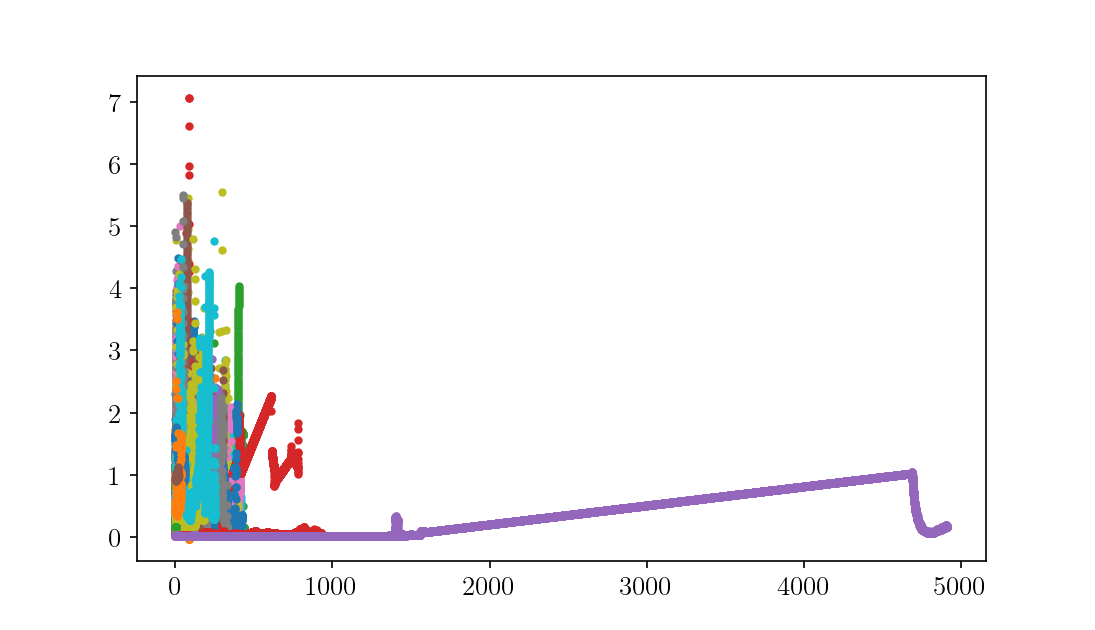

In [208]:
plt.figure()
for i,j in enumerate(dvals['cdist_n']):
    try:
        plt.plot(j,dvals['aod_n'][i],'.')
    except:
        pass

<IPython.core.display.Javascript object>


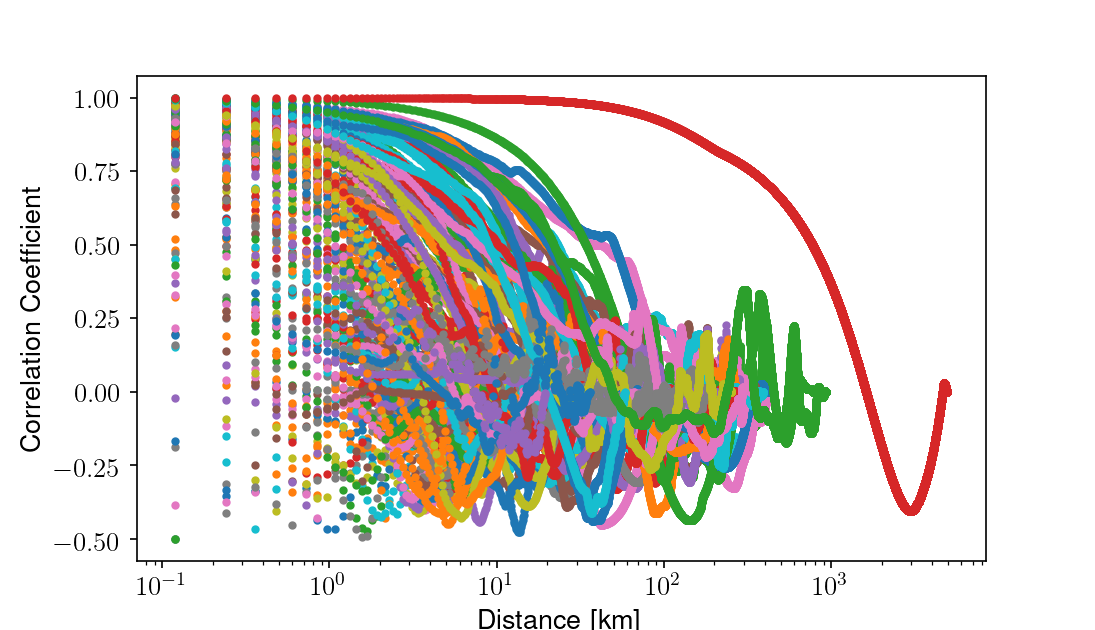

In [209]:
plt.figure()
for i,j in enumerate(dvals['cdist_n']):
    try:
        plt.plot(j,dvals['autocor'][i],'.')
    except:
        pass
plt.ylabel('Correlation Coefficient')
plt.xlabel('Distance [km]')
plt.xscale('log')

### Autocorrelation plot with Anderson method

In [704]:
key_list = ['aod0500','aod1040','AE','aod_fine','aod_coarse']
legend_list = ['All','Dynamic','Stagnation','Extreme pollution','Blocking','0-1 km','1-3 km','3+ km']
cl_list = ['k','tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:cyan','tab:purple']
m_list = ['.','o','s','v','^','*','+','x']
tit = ['AOD$_{{500}}$','AOD$_{{1040}}$','AE','AOD$_{{fine}}$','AOD$_{{coarse}}$']

<IPython.core.display.Javascript object>


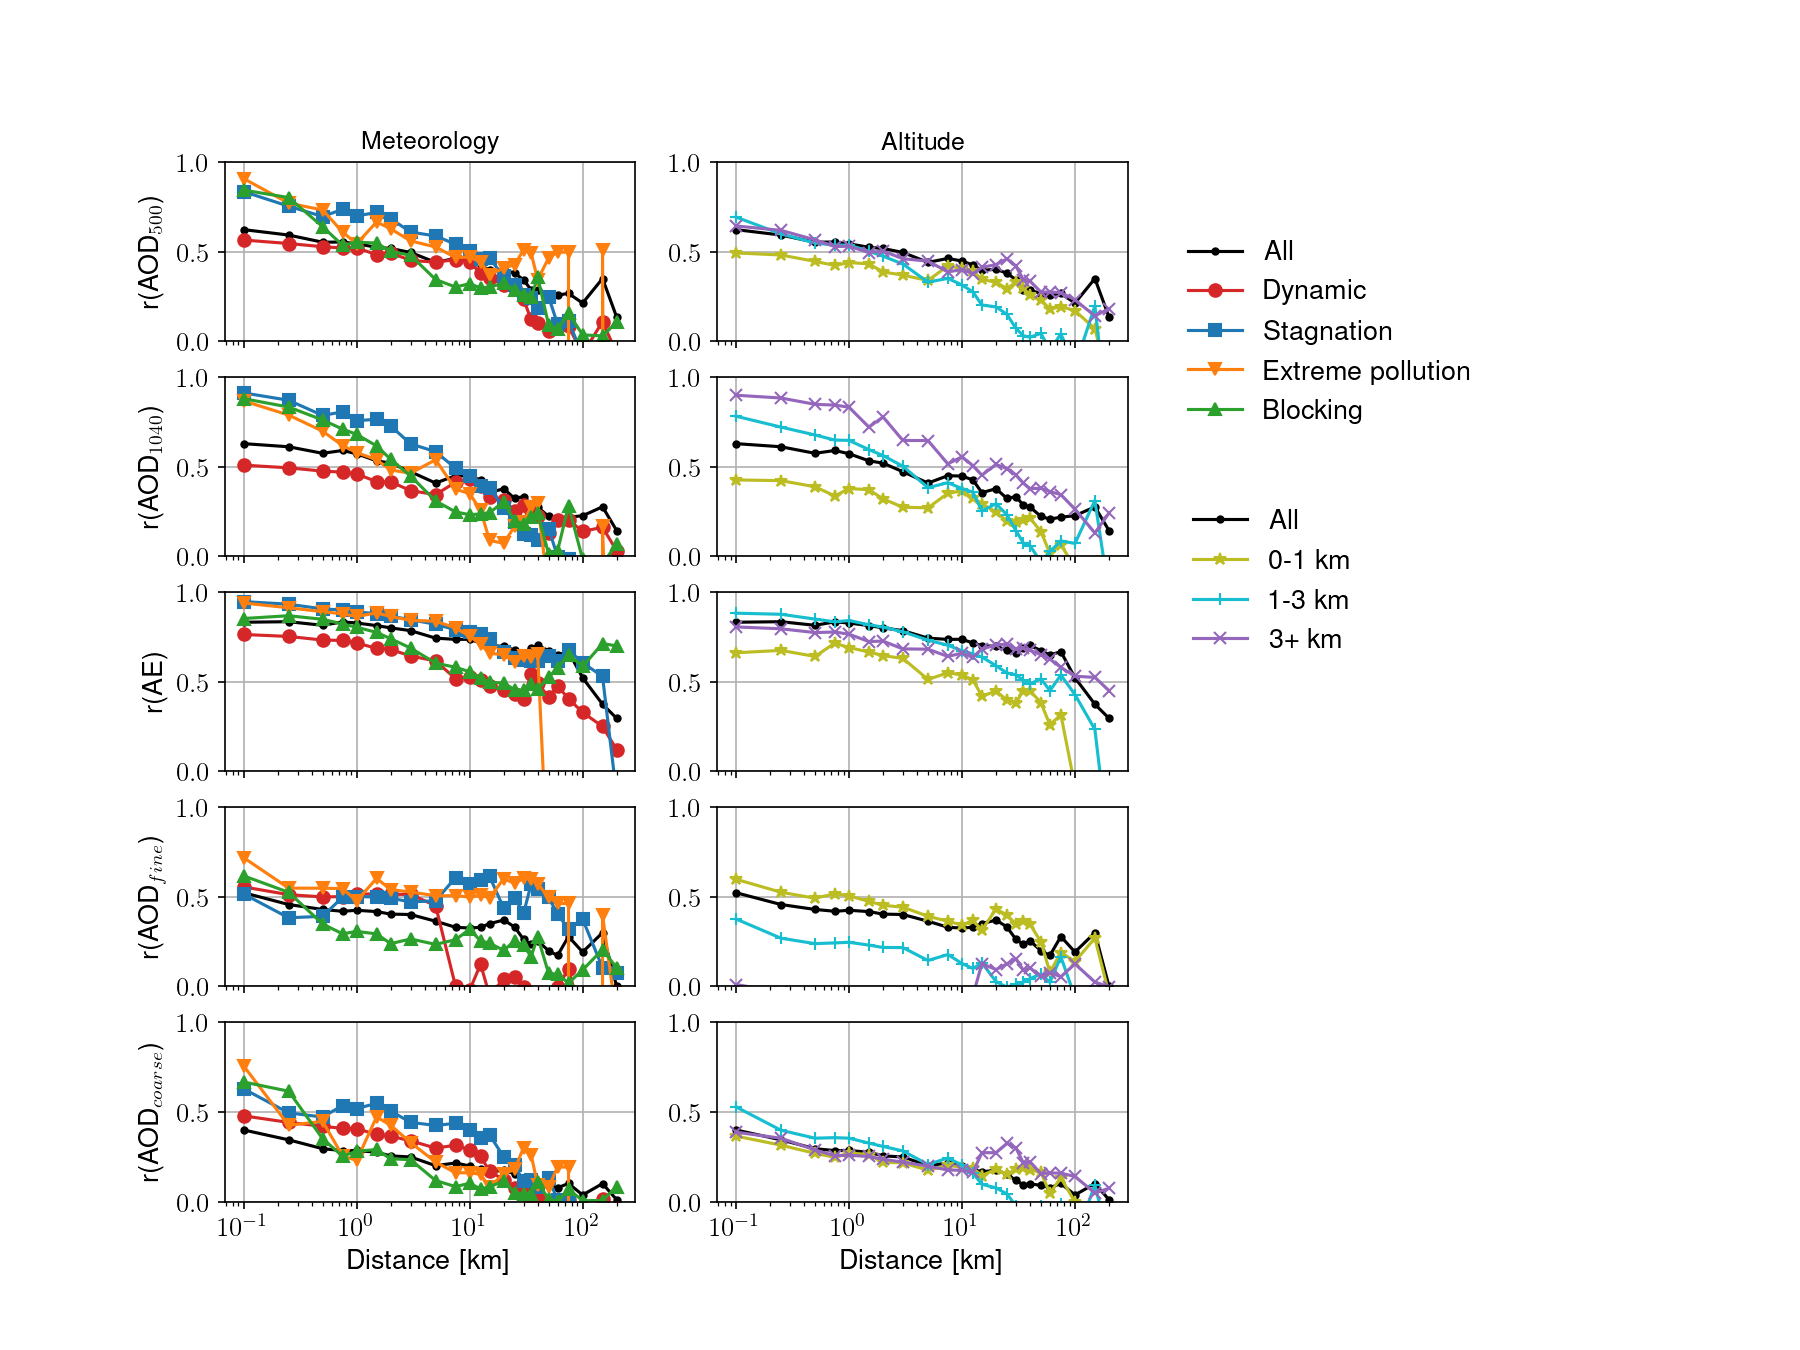

In [705]:
fig, ax = plt.subplots(5,3,figsize=(12,9))
for i,k in enumerate(key_list):
    for j in [0,1,2,3,4]:
        ax[i,0].plot(corr_ks,autocorr[k][j,:],label=legend_list[j],color=cl_list[j],marker=m_list[j])
    for j in [0,5,6,7]:    
        ax[i,1].plot(corr_ks,autocorr[k][j,:],label=legend_list[j],color=cl_list[j],marker=m_list[j])
    ax[i,0].set_ylim(0,1)
    ax[i,1].set_ylim(0,1)
    ax[i,0].set_xscale('log')
    ax[i,1].set_xscale('log')
    ax[i,0].grid()
    ax[i,1].grid()
    
    ax[i,2].set_visible(False)
    
    #print 'r({})'.format(k)
    ax[i,0].set_ylabel('r({})'.format(tit[i]))
    plt.setp(ax[i,0].get_xticklabels(), visible=False)
    plt.setp(ax[i,1].get_xticklabels(), visible=False)
    
    if i==0:
        ax[i,0].set_title('Meteorology')
        ax[i,1].set_title('Altitude')
    if i==1:
        ax[i,0].legend(frameon=False,bbox_to_anchor=[3.1,1.9])
        ax[i,1].legend(frameon=False,bbox_to_anchor=[1.1,0.4])
    if i==4:
        ax[i,0].set_xlabel('Distance [km]')
        ax[i,1].set_xlabel('Distance [km]')
        plt.setp(ax[i,0].get_xticklabels(), visible=True)
        plt.setp(ax[i,1].get_xticklabels(), visible=True)

plt.savefig(fp+'plot/KORUS_Autocorr_all.png',dpi=600,transparent=True)

## Load the Autocorrelations from Shinozuka & Redemann

In [706]:
SR_corr_ks = [0.45,1.0,3.0,6.0,10.0,20.0,34.2]
SR_aod_corr_long = [0.998,0.997,0.995,0.985,0.981,0.946,0.917]
SR_aod_corr_loc = [0.975,0.941,0.830,0.712,0.584,0.365,0.328]
SR_AE_corr_long = [1.000,0.977,0.975,0.960,0.944,0.913,0.919]
SR_AE_corr_loc = [0.975,0.956,0.919,0.831,0.747,0.519,0.366]

In [ ]:
#AOD local

0,4376084276355722; 0,9757725145572111
0,9955912496957824; 0,9408298503197231
2,993269282069332; 0,8303668774336445
5,997701705897239; 0,711850105383489
9,981245014250291; 0,5844939806380168
20,005524337736603; 0,36462079805665715
35,166804844012965; 0,32825206301575405

In [ ]:
#AE local
0,43836153494904556; 0,9757721573250459
0,9972623352215253; 0,9556260493694856
2,9925078192756667; 0,9191462151252102
5,985354161428386; 0,8309627406851716
9,993780925398312; 0,7465159146929592
19,996703813167056; 0,5185049833887045
35,22351663341235; 0,36598292430250434

In [ ]:
#AOD long
0,43833272405336876; 0,9987068195620337
0,9971397077970326; 0,9985360625870756
2,9918543848699146; 0,9953484799771375
6,0033122296001995; 0,985586039366985
9,969908496905848; 0,9810416889936774
19,972213345966814; 0,9461254599364131
35,10743016861416; 0,9178948308505701

In [ ]:
#AE long
0,43757781072798063; 1,0001868324223917
0,9989150464154728; 0,9778205265602119
2,992025659700471; 0,9753731289965352
5,9831337971357215; 0,9604326081520385
9,970944322675367; 0,9447901261029547
19,97407661698948; 0,9135730361161722
35,10728129935923; 0,9193744864787629

In [712]:
note = [['a)','b)'],['c)','d)'],['e)','f)'],['g)','h)'],['i)','j)']]

In [716]:
reload(pu)

<module 'plotting_utils' from 'plotting_utils.py'>

<IPython.core.display.Javascript object>


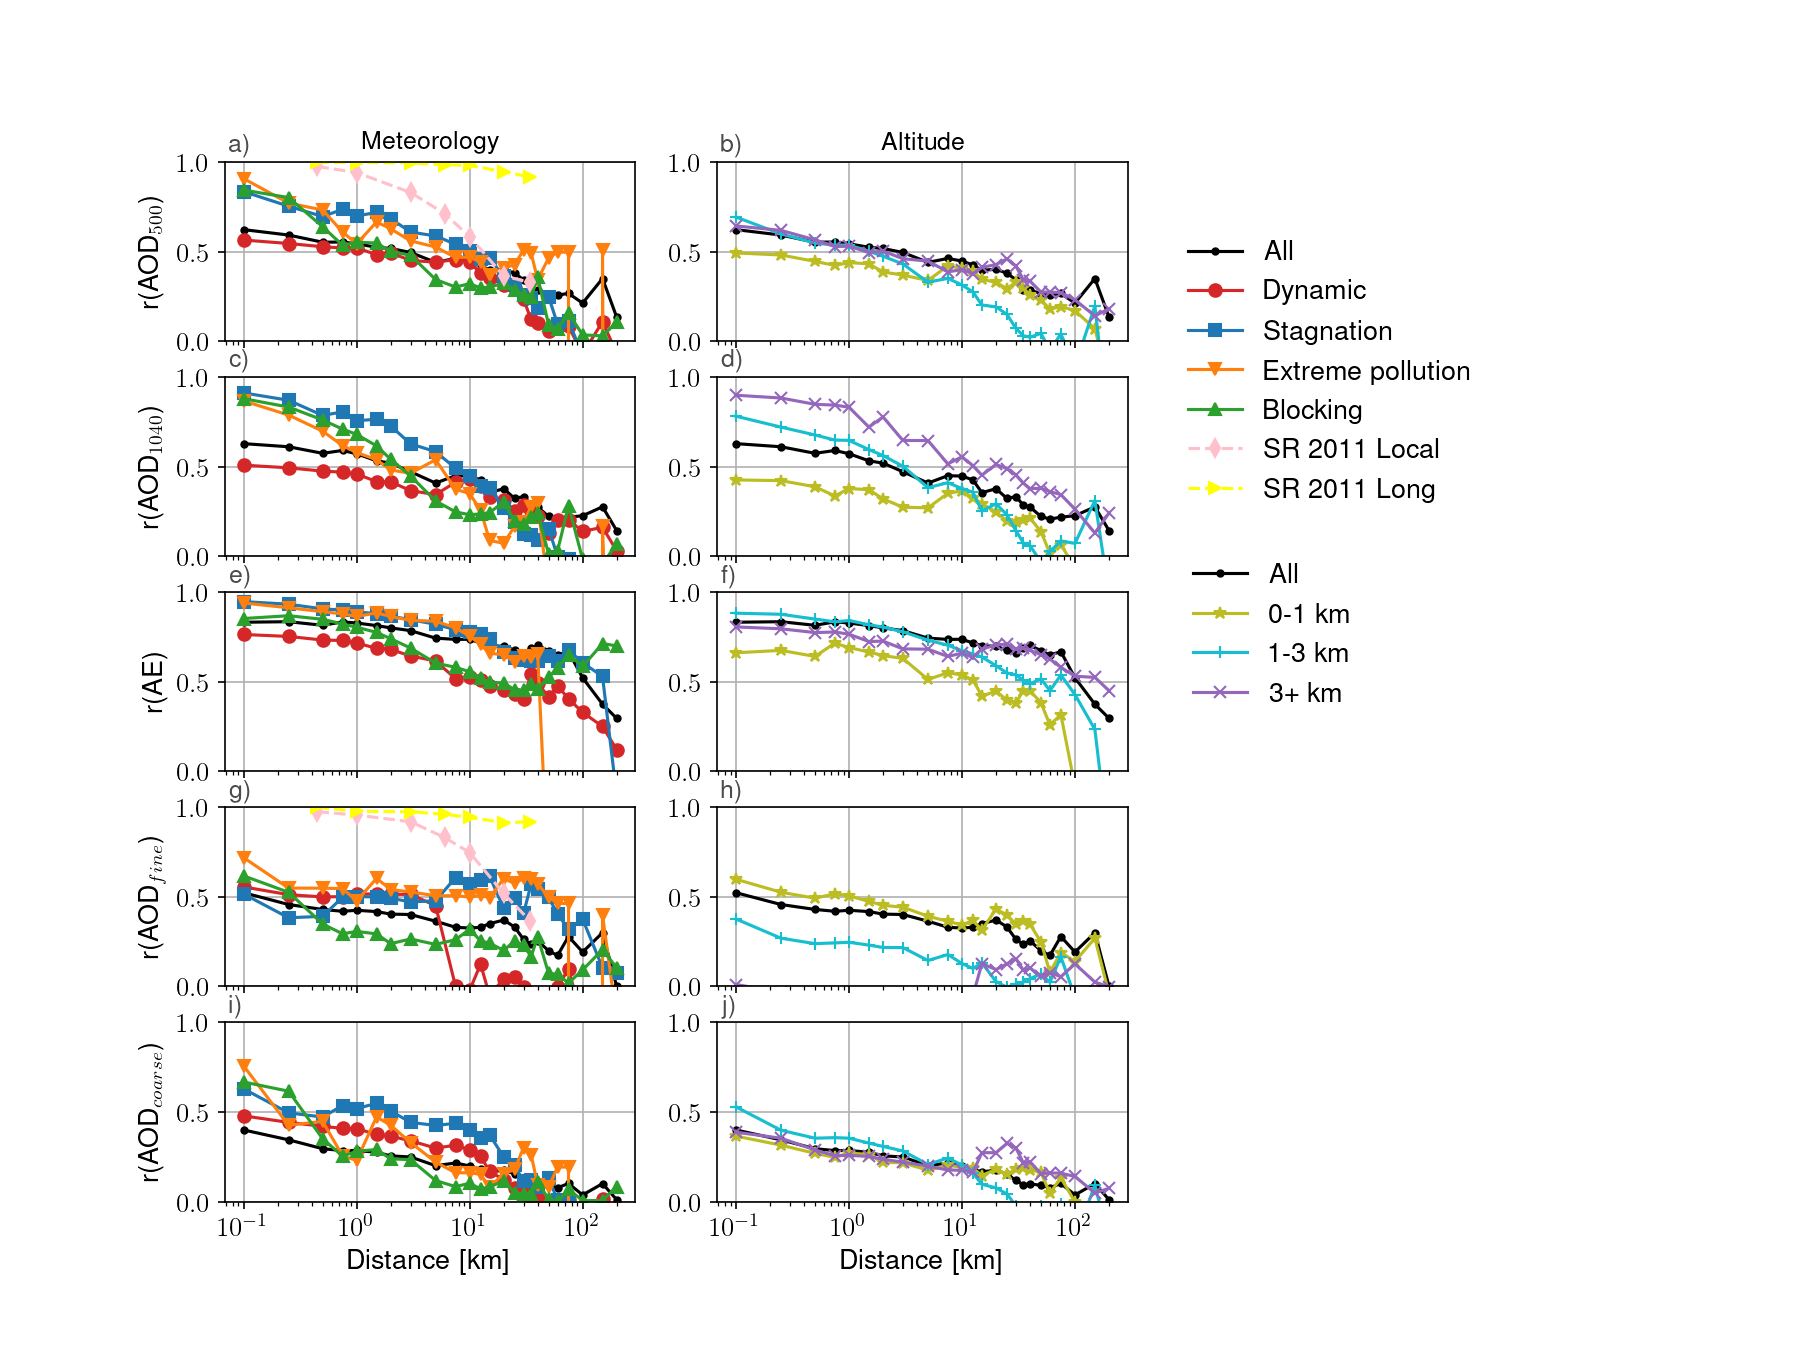

In [718]:
fig, ax = plt.subplots(5,3,figsize=(12,9))
for i,k in enumerate(key_list):
    for j in [0,1,2,3,4]:
        ax[i,0].plot(corr_ks,autocorr[k][j,:],label=legend_list[j],color=cl_list[j],marker=m_list[j])
    for j in [0,5,6,7]:    
        ax[i,1].plot(corr_ks,autocorr[k][j,:],label=legend_list[j],color=cl_list[j],marker=m_list[j])
    ax[i,0].set_ylim(0,1)
    ax[i,1].set_ylim(0,1)
    ax[i,0].set_xscale('log')
    ax[i,1].set_xscale('log')
    ax[i,0].grid()
    ax[i,1].grid()
    
    ax[i,2].set_visible(False)
    
    #print 'r({})'.format(k)
    ax[i,0].set_ylabel('r({})'.format(tit[i]))
    plt.setp(ax[i,0].get_xticklabels(), visible=False)
    plt.setp(ax[i,1].get_xticklabels(), visible=False)
    pu.sub_note(note[i][0],ax=ax[i,0],out=True,fontsize=12)
    pu.sub_note(note[i][1],ax=ax[i,1],out=True,fontsize=12)
    
    if i==0:
        ax[i,0].set_title('Meteorology')
        ax[i,1].set_title('Altitude')
        
        ax[i,0].plot(SR_corr_ks,SR_aod_corr_loc,'d--',c='pink',label='SR 2011 Local')
        ax[i,0].plot(SR_corr_ks,SR_aod_corr_long,'>--',c='yellow',label='SR 2011 Long')
        
    if i==1:
        ax[i,0].plot([],[],'d--',c='pink',label='SR 2011 Local')
        ax[i,0].plot([],[],'>--',c='yellow',label='SR 2011 Long')
        ax[i,0].legend(frameon=False,bbox_to_anchor=[3.1,1.9])
        ax[i,1].legend(frameon=False,bbox_to_anchor=[1.1,0.1])
    
    if i==3:
        ax[i,0].plot(SR_corr_ks,SR_AE_corr_loc,'d--',c='pink',label='SR 2011 Local')
        ax[i,0].plot(SR_corr_ks,SR_AE_corr_long,'>--',c='yellow',label='SR 2011 Long')
    
    if i==4:
        ax[i,0].set_xlabel('Distance [km]')
        ax[i,1].set_xlabel('Distance [km]')
        plt.setp(ax[i,0].get_xticklabels(), visible=True)
        plt.setp(ax[i,1].get_xticklabels(), visible=True)

plt.savefig(fp+'plot/KORUS_Autocorr_all_with_SR2011.png',dpi=600,transparent=True)

## Now get the angstrom exponent and plot it vertically

In [210]:
nwl,nm

([u'AOD0380',
  u'AOD0452',
  u'AOD0501',
  u'AOD0520',
  u'AOD0532',
  u'AOD0550',
  u'AOD0606',
  u'AOD0620',
  u'AOD0675',
  u'AOD0781',
  u'AOD0865',
  u'AOD1020',
  u'AOD1040',
  u'AOD1064',
  u'AOD1236',
  u'AOD1559',
  u'AOD1627'],
 [380.0,
  452.0,
  501.0,
  520.0,
  532.0,
  550.0,
  606.0,
  620.0,
  675.0,
  781.0,
  865.0,
  1020.0,
  1040.0,
  1064.0,
  1236.0,
  1559.0,
  1627.0])

In [89]:
aodrr = np.array([ar[n] for n in nwl])

In [90]:
aodrr.shape

(17, 583183)

In [91]:
angs = su.calc_angs(ar['Start_UTC'],np.array(nm[1:11]),aodrr[1:11,:])

A Jupyter Widget

Sun_utils.py:607: RuntimeWarning: divide by zero encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))
linfit.py:224: RuntimeWarning: invalid value encountered in double_scalars
  yint = (sy - sx * slope)/s
Sun_utils.py:607: RuntimeWarning: invalid value encountered in log10
  c,cm = linfit(np.log10(w),-np.log10(aod[:,i]))


In [44]:
def make_bined_alt(x,alt,days,fl,n=70):
    'Function to create binned data for a set range, usually for altitude'
    binned_ang,binned_alt,binned_num,binned_ndays = [],[],[],[]
    for i in xrange(70):
        flaa = (alt[fl]>=i*100.0) & (alt[fl]<(i+1.0)*100.0)
        binned_ang.append(x[fl][flaa])
        binned_alt.append(np.mean([i*100.0,(i+1.0)*100.0]))
        binned_num.append(len(x[fl][flaa]))
        binned_ndays.append(len(np.unique(days[fl][flaa])))
    return binned_ang,binned_alt,binned_num,binned_ndays

In [45]:
ar['fl_QA_angs'] = ar['fl'] & (ar['AOD0501']>0.05) 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [46]:
ar['fl_QA_angs_seoul'] = ar['fl'] & (ar['AOD0501']>0.05) & (ar['Latitude']<37.75) &\
                        (ar['Latitude']>36.9) & (ar['Longitude']<127.30) & (ar['Longitude']>126.60)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [47]:
any(ar['fl_QA_angs_seoul'])

True

In [70]:
bang,balt,bnum,bndays = make_bined_alt(angs,ar['GPS_Alt'],ar['days'],ar['fl_QA_angs'],n=90)

In [71]:
bangs,balts,bnums,bndayss = make_bined_alt(angs,ar['GPS_Alt'],ar['days'],ar['fl_QA_angs_seoul'],n=90)

### Plotting of the angstrom vertical dependence

<IPython.core.display.Javascript object>


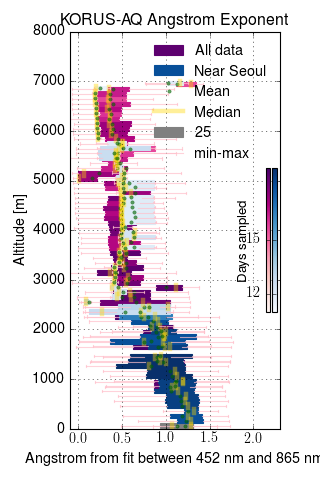

In [128]:
plt.figure(figsize=(4,6))
bp =plt.boxplot(bang,positions=np.array(balt)-5.0,vert=False,
                showfliers=False,widths=90,showmeans=True,patch_artist=True)
plt.xlabel('Angstrom from fit between 452 nm and 865 nm')
plt.ylabel('Altitude [m]')
gr = plt.cm.RdPu
bl = plt.cm.Blues
pu.set_box_whisker_color(gr,bp,bndays)
    
bpc =plt.boxplot(bangs,positions=np.array(balts)+10.0,vert=False,
                 showfliers=False,widths=90,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(bl,bpc,bndayss)
bpc['boxes'][0].set_color('grey')

ax = plt.gca()
plt.title('KORUS-AQ Angstrom Exponent')
plt.ylim(0,8000)
plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.xlim(-0.1,2.3)
plt.grid()
plt.legend([bp['boxes'][5],bpc['boxes'][18],bpc['means'][0],bpc['medians'][0],bpc['boxes'][0],bpc['whiskers'][0]],
           ['All data','Near Seoul','Mean','Median','25% - 75%','min-max'],
           frameon=False,loc=1,numpoints=1)

scalarmapgr = plt.cm.ScalarMappable(cmap=gr)
scalarmapgr.set_array(bndays)
scalarmapbl = plt.cm.ScalarMappable(cmap=bl)
scalarmapbl.set_array(bndays)
cbaxesgr = plt.gcf().add_axes([0.83, 0.35, 0.015, 0.3])
cbg = plt.colorbar(scalarmapgr,cax=cbaxesgr)
cbaxesbl = plt.gcf().add_axes([0.85, 0.35, 0.015, 0.3])
cbb = plt.colorbar(scalarmapbl,cax=cbaxesbl)
cbg.set_ticks([0,3,6,9,12,15])
cbb.set_ticks([0,3,6,9,12,15]),cbb.set_ticklabels(['','','','',''])
cbaxesgr.yaxis.set_ticks_position('left'),cbaxesbl.yaxis.set_ticks_position('left')
cbaxesgr.text(-6.0,0.5,'Days sampled',rotation=90,verticalalignment='center')

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_Angstrom_fit_vertical.png',
            transparent=True,dpi=500)

## Analyse the Fine mode fraction

In [50]:
ar['fl_QA_low'] = ar['fl_QA'] & (ar['GPS_Alt']<500.0)
ar['fl_QA_mid'] = ar['fl_QA'] & (ar['GPS_Alt']>2000.0) & (ar['GPS_Alt']<5000.0) 


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [51]:
ar['fl_QA_fmf'] = ar['fl_QA'] & (np.isfinite(fmf['tauf'])) & (np.isfinite(fmf['tauc']))

In [52]:
bfaod,baltf,bnumf,bndaysf = make_bined_alt(fmf['tauf'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)
bcaod,baltc,bnumc,bndaysc = make_bined_alt(fmf['tauc'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)
beta,balte,bnume,bndayse = make_bined_alt(fmf['eta'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)

In [53]:
blat,baltl,bnuml,bndaysl = make_bined_alt(ar['Latitude'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)
blon,baltlo,bnumlo,bndayslo = make_bined_alt(ar['Longitude'],ar['GPS_Alt'],ar['days'],ar['fl_QA_fmf'],n=90)

583185/|/100%|| 583185/583185 [01:35<00:00, 7578.34it/s]

In [54]:
blats = [np.nanmedian(ll) for ll in blat]
blons = [np.nanmedian(ll) for ll in blon]

In [90]:
blons

[-149.98910000000001,
 126.12313779999999,
 126.65381360000001,
 126.4886552,
 127.1281,
 127.32114919999999,
 127.2359708,
 127.2046137,
 127.14304390000001,
 127.1601344,
 127.1606122,
 127.00119480000001,
 126.90518785,
 127.42745955000001,
 126.95736264999999,
 127.02680789999999,
 127.3059449,
 127.3743758,
 127.3411138,
 127.32306635,
 127.47791185,
 127.2584296,
 127.2898993,
 127.47796245000001,
 126.8234029,
 126.92522649999999,
 127.51896975,
 127.47839999999999,
 126.87634489999999,
 127.52080530000001,
 127.47686179999999,
 128.39919265,
 127.46392815,
 127.467461,
 128.41734845000002,
 127.469979,
 127.4882752,
 127.50116735,
 126.82570990000001,
 127.531677,
 127.55323344999999,
 127.58127114999999,
 126.99032579999999,
 127.6203627,
 127.63433664999999,
 127.63790815,
 127.6442557,
 124.2892319,
 127.6469683,
 127.63876740000001,
 126.95364925,
 127.3740899,
 127.5705,
 127.46281429999999,
 127.56150839999999,
 127.54370900000001,
 127.51926324999999,
 127.48308965,
 127

### Plot the fine mode fraction distribution

<IPython.core.display.Javascript object>


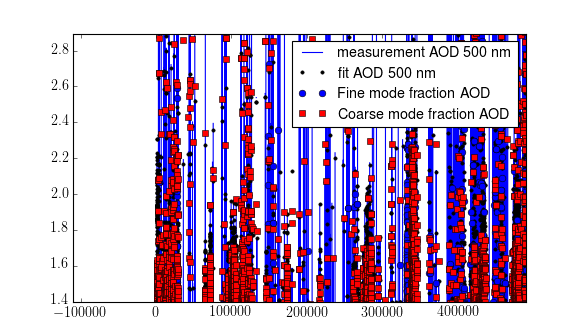

(0, 1.5)

In [87]:
plt.figure()
plt.plot(aodrr[2,:],label='measurement AOD 500 nm')
plt.plot(fmf['tau'],'.k',label='fit AOD 500 nm')
plt.plot(fmf['tauf'], 'ob',label='Fine mode fraction AOD')
plt.plot(fmf['tauc'],'sr',label='Coarse mode fraction AOD')
plt.legend()
plt.ylim(0,1.5)

<IPython.core.display.Javascript object>


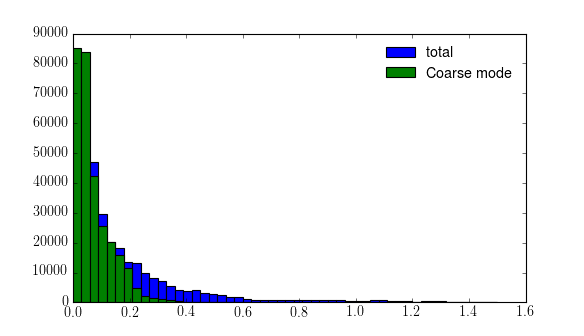

In [96]:
plt.figure()
plt.hist(fmf['tauc'][ar['fl_QA']]+fmf['tauf'][ar['fl_QA']],range=[0,1.5],bins=50,label='total')
plt.hist(fmf['tauc'][ar['fl_QA']],range=[0,1.5],bins=50,label='Coarse mode')
plt.legend(frameon=False)

In [106]:
any(ar['fl_QA_mid'])

True

### Plot the histogram distribution of the fine mode fraction

<IPython.core.display.Javascript object>


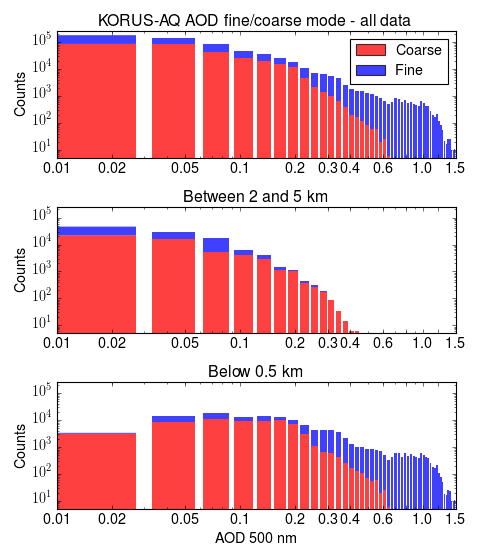

In [61]:
plt.figure(figsize=(6,7))
ax1 = plt.subplot(3,1,1)
plt.hist([fmf['tauc'][ar['fl_QA']],fmf['tauf'][ar['fl_QA']]],color=['r','b'],histtype='bar',
            bins=50,range=[0.0,1.5],label=['Coarse','Fine'],edgecolor='None',alpha=0.75,normed=False,stacked=True)
plt.legend(frameon=True,loc=1)
plt.title('KORUS-AQ AOD fine/coarse mode - all data')
#plt.xlabel('AOD 500 nm')
plt.ylabel('Counts')
plt.yscale('log'),plt.xscale('log')
plt.ylim(5,250000),plt.xlim(0.01,1.5)
plt.xticks([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.5])
ax1.set_xticklabels([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,'',1.0,'',1.5])

ax2 = plt.subplot(3,1,2,sharex=ax1)
plt.hist([fmf['tauc'][ar['fl_QA_mid']],fmf['tauf'][ar['fl_QA_mid']]],color=['r','b'],histtype='bar',
            bins=50,range=[0.0,1.5],label=['Coarse','Fine'],edgecolor='None',alpha=0.75,normed=False,stacked=True)
#plt.legend(frameon=False)
plt.title('Between 2 and 5 km')
plt.ylabel('Counts')
plt.yscale('log'),plt.xscale('log')
plt.ylim(5,250000),plt.xlim(0.01,1.5)
plt.xticks([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.5])
ax2.set_xticklabels([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,'',1.0,'',1.5])

ax3 = plt.subplot(3,1,3,sharex=ax2)
plt.hist([fmf['tauc'][ar['fl_QA_low']],fmf['tauf'][ar['fl_QA_low']]],color=['r','b'],histtype='bar',
            bins=50,range=[0.0,1.5],label=['Coarse','Fine'],edgecolor='None',alpha=0.75,normed=False,stacked=True)
#plt.legend(frameon=False)
plt.title('Below 0.5 km')
#plt.xlabel('AOD 500 nm')
plt.ylabel('Counts')
plt.yscale('log'),plt.xscale('log')
plt.ylim(5,250000),plt.xlim(0.01,1.5)
plt.xlabel('AOD 500 nm')
plt.xticks([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2,1.5])
ax3.set_xticklabels([0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.6,'',1.0,'',1.5])

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_fine_mode_hist.png',
            transparent=True,dpi=500)

### Plot the vertical dependence of the fine mode fraction

<IPython.core.display.Javascript object>


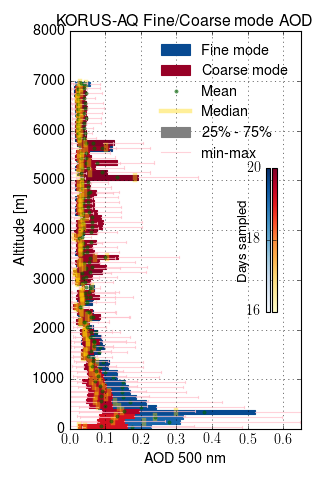

In [110]:
plt.figure(figsize=(4,6))
bp =plt.boxplot(bfaod,positions=np.array(baltf)-5.0,vert=False,
                showfliers=False,widths=90,showmeans=True,patch_artist=True)
plt.xlabel('AOD 500 nm')
plt.ylabel('Altitude [m]')
bl = plt.cm.YlOrRd
gr = plt.cm.Blues
pu.set_box_whisker_color(gr,bp,bndaysf)
    
bpc =plt.boxplot(bcaod,positions=np.array(baltc)+10.0,vert=False,
                 showfliers=False,widths=90,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(bl,bpc,bndaysc)
bpc['boxes'][-1].set_color('grey')

ax = plt.gca()
plt.title('KORUS-AQ Fine/Coarse mode AOD')
plt.ylim(0,8000)
plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.xlim(0.0,0.65)
plt.grid()
plt.legend([bp['boxes'][5],bpc['boxes'][18],bpc['means'][0],bpc['medians'][0],bpc['boxes'][-1],bpc['whiskers'][0]],
           ['Fine mode','Coarse mode','Mean','Median','25\% - 75\%','min-max'],
           frameon=False,loc=1,numpoints=1)

scalarmapgr = plt.cm.ScalarMappable(cmap=gr)
scalarmapgr.set_array(bndaysf)
scalarmapbl = plt.cm.ScalarMappable(cmap=bl)
scalarmapbl.set_array(bndaysc)
cbaxesgr = plt.gcf().add_axes([0.83, 0.35, 0.015, 0.3])
cbg = plt.colorbar(scalarmapgr,cax=cbaxesgr)
cbaxesbl = plt.gcf().add_axes([0.85, 0.35, 0.015, 0.3])
cbb = plt.colorbar(scalarmapbl,cax=cbaxesbl)
cbg.set_ticks([0,6,12,16,18,20])
cbb.set_ticks([0,6,12,16,18,20]),cbb.set_ticklabels(['','','','',''])
cbaxesgr.yaxis.set_ticks_position('left'),cbaxesbl.yaxis.set_ticks_position('left')
cbaxesgr.text(-6.0,0.5,'Days sampled',rotation=90,verticalalignment='center')

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_fine_mode_AOD_vertical.png',
            transparent=True,dpi=500)

In [56]:
blats[0]=36.2

In [57]:
bndm = np.nanmax(blats)*1.0
bndm

37.594356000000005

In [100]:
cl = gr
for j,q in enumerate(blats):
    print j, q, cl(blats[j]*1.0/bndm)

0 36.2 (0.031372550874948502, 0.22477509221609901, 0.47386390847318316, 1.0)
1 35.6241051 (0.031372550874948502, 0.24101500084587171, 0.49797771315948636, 1.0)
2 36.2642631 (0.031372550874948502, 0.22477509221609901, 0.47386390847318316, 1.0)
3 36.4941735 (0.031372550874948502, 0.21665513790121266, 0.46180700613003151, 1.0)
4 36.1079282 (0.031372550874948502, 0.2288350693735422, 0.47989235964475896, 1.0)
5 36.6140062 (0.031372550874948502, 0.2125951607437695, 0.45577855495845571, 1.0)
6 36.4494213 (0.031372550874948502, 0.21665513790121266, 0.46180700613003151, 1.0)
7 36.8572909 (0.031372550874948502, 0.20853518358632631, 0.44975010378687991, 1.0)
8 36.98560035 (0.031372550874948502, 0.20447520642888312, 0.44372165261530405, 1.0)
9 36.149323 (0.031372550874948502, 0.22477509221609901, 0.47386390847318316, 1.0)
10 37.0671798 (0.031372550874948502, 0.20041522927143995, 0.43769320144372825, 1.0)
11 36.53188675 (0.031372550874948502, 0.21665513790121266, 0.46180700613003151, 1.0)
12 36.123

<IPython.core.display.Javascript object>


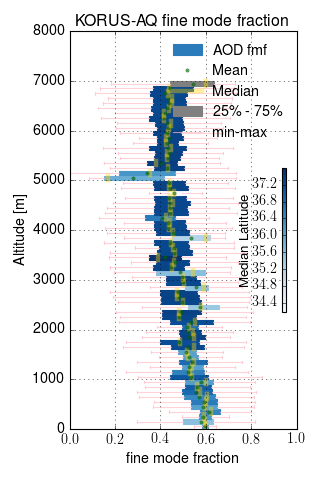

In [111]:
plt.figure(figsize=(4,6))
bp =plt.boxplot(beta,positions=np.array(balte),vert=False,
                showfliers=False,widths=90,showmeans=True,patch_artist=True)
plt.xlabel('fine mode fraction')
plt.ylabel('Altitude [m]')
bl = plt.cm.YlOrRd
gr = plt.cm.Blues
pu.set_box_whisker_color(gr,bp,blats,color_not_start_at_zero=True)
    
#bpc =plt.boxplot(bcaod,positions=np.array(baltc)+10.0,vert=False,
#                 showfliers=False,widths=90,showmeans=True,patch_artist=True)
#pu.set_box_whisker_color(bl,bpc,bndaysc)
bp['boxes'][-1].set_color('grey')

ax = plt.gca()
plt.title('KORUS-AQ fine mode fraction')
plt.ylim(0,8000)
plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000])
plt.xlim(0.0,1.0)
plt.grid()
plt.legend([bp['boxes'][5],bp['means'][5],bp['medians'][5],bp['boxes'][-1],bp['whiskers'][5]],
           ['AOD fmf','Mean','Median','25\% - 75\%','min-max'],
           frameon=False,loc=1,numpoints=1)

scalarmapgr = plt.cm.ScalarMappable(cmap=gr)
scalarmapgr.set_array(blats)
#scalarmapbl = plt.cm.ScalarMappable(cmap=bl)
#scalarmapbl.set_array(bndays)
cbaxesgr = plt.gcf().add_axes([0.88, 0.35, 0.015, 0.3])
cbg = plt.colorbar(scalarmapgr,cax=cbaxesgr)
#cbaxesbl = plt.gcf().add_axes([0.85, 0.35, 0.015, 0.3])
#cbb = plt.colorbar(scalarmapbl,cax=cbaxesbl)
#cbg.set_ticks([0,6,12,15,18])
#cbb.set_ticks([0,6,12,15,18]),cbb.set_ticklabels(['','','','',''])
cbaxesgr.yaxis.set_ticks_position('left')#,cbaxesbl.yaxis.set_ticks_position('left')
cbaxesgr.text(-9.0,0.5,'Median Latitude',rotation=90,verticalalignment='center')

plt.tight_layout()

plt.savefig(fp+'plot/KORUS_4STAR_fine_mode_AOD_vertical.png',
            transparent=True,dpi=500)

## Calculate the autocorrelation of the fine and coarse mode AOD

In [55]:
fvals = {'utc':ar['Start_UTC'][fl],'alt':ar['GPS_Alt'][fl],'lat':ar['Latitude'][fl],'lon':ar['Longitude'][fl],
        'aod0500':ar['AOD0501'][fl],'aod1040':ar['AOD1040'][fl],'aodf':fmf['tauf'][fl],'aodc':fmf['tauc'][fl],'eta':fmf['eta'][fl]}

In [56]:
dfvals = get_segments(f_level,fvals,nsep=100)

In [57]:
ddfv = get_distances(dfvals)

Now the segments are identified and the cumulative distances are quantified, we must interpolate over the segments, to remove any missing data.

In [58]:
def interp_dist_fmf(d,dist=0.12):
    'function to insterpolate the AOD from the dict to an even grid spacing accroding to distance (default 0.12 km)'
    d['cdist_n'],d['aod_nf'],d['aod_nc'],d['eta_n'] = [],[],[],[]
    for i,cd in enumerate(d['cumdist']):        
        d['cdist_n'].append(np.arange(cd.min(),cd.max(),dist))
        if np.sum(np.isfinite(d['aodf'][i]))/float(len(d['aodf'][i])) < 0.75: # check if at least 75% of the segment is valid
            af = np.array(np.nan)
            ac = np.array(np.nan)
            et = np.array(np.nan)
        else:
            try:
                fcdf = interpolate.interp1d(cd,d['aodf'][i])
                af = fcdf(d['cdist_n'][i])
                fcdc = interpolate.interp1d(cd,d['aodc'][i])
                ac = fcdc(d['cdist_n'][i])
                fcde = interpolate.interp1d(cd,d['eta'][i])
                et = fcde(d['cdist_n'][i])
            except TypeError:
                af = np.array(np.nan)
                ac = np.array(np.nan)
                et = np.array(np.nan)
        d['aod_nf'].append(af)
        d['aod_nc'].append(ac)
        d['eta_n'].append(et)

In [59]:
interp_dist_fmf(dfvals)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


In [79]:
dfvals['autocor_f'],dfvals['autocor_c'],dfvals['autocor_e'] = [] ,[],[]
for i,a in enumerate(dfvals['aod_nf']):
    #auf,auc,eut = [],[],[]
    try:
        auf = autocorr5(a)
        auc = autocorr5(dfvals['aod_nc'][i])
        eut = autocorr5(dfvals['eta_n'][i])
    except:
        auf = np.array([np.nan])
        auc = np.array([np.nan])
        eut = np.array([np.nan])
    dfvals['autocor_f'].append(auf[:])
    dfvals['autocor_c'].append(auc[:])
    dfvals['autocor_e'].append(eut[:])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


In [61]:
len(dfvals['aod_nf'])

254

In [63]:
dfvals['aod_nf'][i]

array([ 0.21168928,  0.21168928,  0.22265097,  0.18114966,  0.16894319,
        0.14674936,  0.14672834,  0.15728576,  0.15866941,  0.15583983,
        0.15088238,  0.14901555,  0.16081026,  0.14932608,  0.1555551 ,
        0.17023048,  0.17848   ,  0.18110492,  0.17049711,  0.16931724,
        0.18223482,  0.14611177,  0.1545911 ,  0.13131177,  0.1258004 ,
        0.12972138,  0.13774946,  0.12761112,  0.13404419,  0.12955565,
        0.12202962,  0.1221877 ,  0.12350845,  0.1254407 ,  0.12568505,
        0.12544021,  0.13007457,  0.1446063 ,  0.15497749,  0.15668431,
        0.1568587 ,  0.15655648,  0.15642829,  0.14921399,  0.15069467,
        0.15802497,  0.15902921,  0.16477269,  0.1716531 ,  0.16922366,
        0.17200509,  0.1778292 ,  0.18154031,  0.17671224,  0.17589078,
        0.19670331,  0.16789232,  0.1615145 ,  0.17067411,  0.16942956,
        0.1661013 ,  0.1644251 ,  0.15779499,  0.16391675,  0.16363495,
        0.15439554,  0.15441867,  0.15563899,  0.16139322,  0.15

In [64]:
dfvals['cdist_n'][i]

array([  0.  ,   0.12,   0.24,   0.36,   0.48,   0.6 ,   0.72,   0.84,
         0.96,   1.08,   1.2 ,   1.32,   1.44,   1.56,   1.68,   1.8 ,
         1.92,   2.04,   2.16,   2.28,   2.4 ,   2.52,   2.64,   2.76,
         2.88,   3.  ,   3.12,   3.24,   3.36,   3.48,   3.6 ,   3.72,
         3.84,   3.96,   4.08,   4.2 ,   4.32,   4.44,   4.56,   4.68,
         4.8 ,   4.92,   5.04,   5.16,   5.28,   5.4 ,   5.52,   5.64,
         5.76,   5.88,   6.  ,   6.12,   6.24,   6.36,   6.48,   6.6 ,
         6.72,   6.84,   6.96,   7.08,   7.2 ,   7.32,   7.44,   7.56,
         7.68,   7.8 ,   7.92,   8.04,   8.16,   8.28,   8.4 ,   8.52,
         8.64,   8.76,   8.88,   9.  ,   9.12,   9.24,   9.36,   9.48,
         9.6 ,   9.72,   9.84,   9.96,  10.08,  10.2 ,  10.32,  10.44,
        10.56,  10.68,  10.8 ,  10.92,  11.04,  11.16,  11.28,  11.4 ,
        11.52,  11.64,  11.76,  11.88,  12.  ,  12.12,  12.24,  12.36,
        12.48,  12.6 ,  12.72,  12.84,  12.96,  13.08,  13.2 ,  13.32,
      

In [80]:
dfvals['autocor_f'][i]

array([             nan,              nan,              nan, ...,
         1.11008864e-05,   2.89227404e-06,  -5.78250967e-06])

In [111]:
mc = np.max([len(m) for m in dfvals['autocor_c']])
imc = np.argmax([len(m) for m in dfvals['autocor_c']])

In [113]:
cdist = dfvals['cdist_n'][imc]

In [123]:
autocor_c = np.zeros((len(dfvals['autocor_c']),mc))+np.nan
autocor_f = np.zeros((len(dfvals['autocor_f']),mc))+np.nan
autocor_e = np.zeros((len(dfvals['autocor_e']),mc))+np.nan

In [124]:
for i,c in enumerate(dfvals['autocor_c']): autocor_c[i,:len(c)]=c
for i,c in enumerate(dfvals['autocor_f']): autocor_f[i,:len(c)]=c
for i,c in enumerate(dfvals['autocor_e']): autocor_e[i,:len(c)]=c

### Plot out the autocorrelation 

<IPython.core.display.Javascript object>


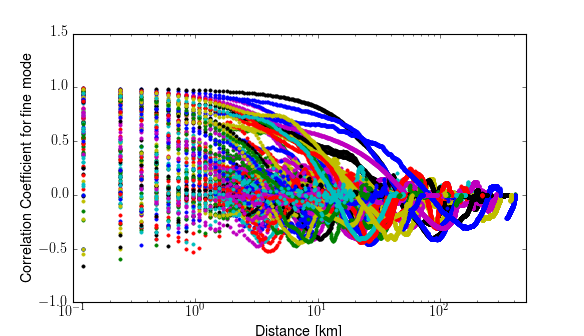

(0.1, 500)

In [83]:
plt.figure()
for i,j in enumerate(dfvals['cdist_n']):
    try:
        if len(j)<1: continue
        plt.plot(j,dfvals['autocor_f'][i],'.')
    except:
        continue
plt.ylabel('Correlation Coefficient for fine mode')
plt.xlabel('Distance [km]')
plt.xscale('log')
plt.xlim(0.1,500)

<IPython.core.display.Javascript object>


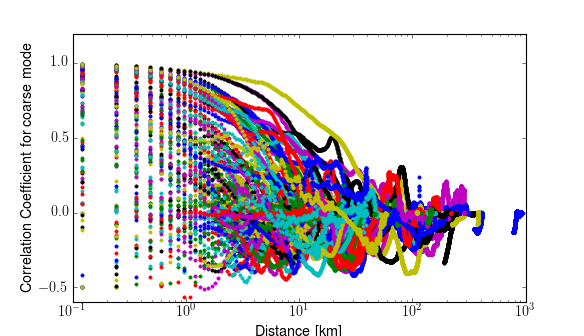

In [84]:
plt.figure()
for i,j in enumerate(dfvals['cdist_n']):
    try:
        plt.plot(j,dfvals['autocor_c'][i],'.')
    except:
        pass
plt.ylabel('Correlation Coefficient for coarse mode')
plt.xlabel('Distance [km]')
plt.xscale('log')

In [110]:
dfvals['cdist_n'][1:3]

[array([  0.  ,   0.12,   0.24,   0.36,   0.48,   0.6 ,   0.72,   0.84,
          0.96,   1.08,   1.2 ,   1.32,   1.44,   1.56,   1.68,   1.8 ,
          1.92,   2.04,   2.16,   2.28,   2.4 ,   2.52,   2.64,   2.76,
          2.88,   3.  ,   3.12,   3.24,   3.36,   3.48,   3.6 ,   3.72,
          3.84,   3.96,   4.08,   4.2 ,   4.32,   4.44,   4.56,   4.68,
          4.8 ,   4.92,   5.04,   5.16,   5.28,   5.4 ,   5.52,   5.64,
          5.76,   5.88,   6.  ,   6.12,   6.24,   6.36,   6.48,   6.6 ,
          6.72,   6.84,   6.96,   7.08,   7.2 ,   7.32,   7.44,   7.56,
          7.68,   7.8 ,   7.92,   8.04,   8.16,   8.28,   8.4 ,   8.52,
          8.64,   8.76,   8.88,   9.  ,   9.12,   9.24,   9.36,   9.48,
          9.6 ,   9.72,   9.84,   9.96,  10.08,  10.2 ,  10.32,  10.44,
         10.56,  10.68,  10.8 ,  10.92,  11.04,  11.16,  11.28,  11.4 ,
         11.52,  11.64,  11.76,  11.88,  12.  ,  12.12,  12.24,  12.36,
         12.48,  12.6 ,  12.72,  12.84,  12.96,  13.08,  13.2 , 

In [133]:
autocor_c_ma = np.ma.masked_array(autocor_c,mask=np.isnan(autocor_c))

In [157]:
def make_binned(x,alt,fl,bn,flb):
    'Function to create binned data for a set range, usually for altitude'
    import numpy as np
    binned_ang,binned_alt,binned_num = [],[],[]
    for i,b in enumerate(bn[:-1]):
        flaa = (alt[flb]>=b) & (alt[flb]<bn[i+1])
        binned_ang.append(x[:,flb][flaa])
        binned_alt.append(np.mean([b,bn[i+1]]))
        binned_num.append(len(x[fl][:,flaa]))
    return binned_ang,binned_alt,binned_num,binned_ndays

In [154]:
bnc = np.logspace(0.1,3.0)

In [155]:
bnc

array([    1.25892541,     1.44272539,     1.6533597 ,     1.89474609,
           2.1713743 ,     2.48838954,     2.85168821,     3.26802759,
           3.74515148,     4.29193426,     4.91854597,     5.63664143,
           6.45957703,     7.40265918,     8.48342898,     9.72198848,
          11.14137457,    12.7679875 ,    14.63208187,    16.76832937,
          19.21646368,    22.0220195 ,    25.23717948,    28.92174481,
          33.14424749,    37.98322505,    43.52868128,    49.8837603 ,
          57.16666502,    65.51285569,    75.0775694 ,    86.03870748,
          98.60014441,   112.99551984,   129.49258422,   148.3981789 ,
         170.06394329,   194.89285531,   223.34672663,   255.95479227,
         293.32355425,   336.14806238,   385.224842  ,   441.46670918,
         505.91974884,   579.78277172,   664.42961191,   761.43467988,
         872.60224609,  1000.        ])

In [163]:
auc = make_binned(autocor_c,cdist,np.isfinite(autocor_c),bnc)

IndexError: too many indices for array

In [161]:
b = bnc[0]
i = 0
fl = np.isfinite(autocor_c)

In [162]:
flaa = (cdist[fl]>=b) & (cdist[fl]<bnc[i+1])

IndexError: too many indices for array

In [156]:
autocor_c.shape

(254, 7728)

<IPython.core.display.Javascript object>


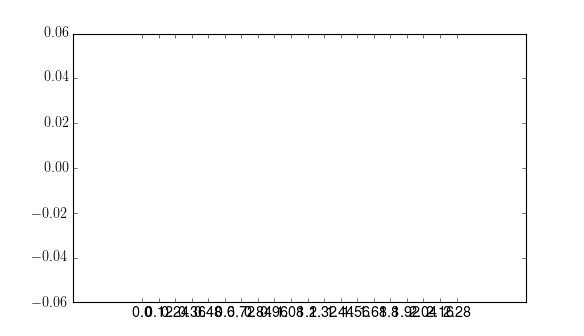

In [135]:
plt.figure()
bp = plt.boxplot(autocor_c_ma[:,0:20],positions=cdist[0:20],vert=True,
            showfliers=False,widths=90,showmeans=True,patch_artist=True) 

In [118]:
autocor_c.shape

(254, 7728)

In [134]:
autocor_c_ma[:,0:20]

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [0.9999999999999999 0.9486627690818289 0.8831168001028755 ...,
  0.039102311665049704 -0.01640918562484604 -0.07094585321604496]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [1.0 0.9001915471544049 0.7544360646884336 ..., -0.38939146620925097
  -0.332314722022007 -0.2539286515417791]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [False False False ..., False False False]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [False False False ..., False False False]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [130]:
np.isfinite(autocor_c)

array([[False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [136]:
autocor_c_ma[:,0]

masked_array(data = [-- 0.9999999999999999 -- -- 0.9999999999999998 1.0 -- 1.0 -- -- --
 1.0000000000000002 1.0 1.0 -- 1.0 1.0 1.0000000000000002 1.0 -- -- -- 1.0
 0.9999999999999998 -- 0.9999999999999999 -- 1.0 -- 1.0 1.0 1.0
 0.9999999999999997 1.0 -- -- 1.0 1.0000000000000004 0.9999999999999999
 0.9999999999999998 -- 1.0 1.0 1.0 1.0 0.9999999999999999 --
 1.0000000000000002 1.0000000000000002 1.0000000000000002 -- 1.0
 0.9999999999999999 -- 1.0 -- -- -- -- -- -- 1.0 -- -- 0.9999999999999998
 -- -- -- -- -- 1.0 0.9999999999999999 1.0000000000000002 -- -- -- 1.0 --
 -- 0.9999999999999999 -- 0.9999999999999998 -- -- 1.0000000000000002
 0.9999999999999998 1.0 -- 1.0000000000000002 -- -- -- -- -- -- -- 1.0 --
 1.0 --],
             mask = [ True False  True  True False False  True False  True  True  True False
 False False  True False False False False  True  True  True False False
  True False  True False  True False False False False False  True  True
 False False False False  True Fal